In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra

In [147]:
ctx = straxbra.XebraContext()
run = '00219'
# peaks_data_xebra = ctx.get_array(run, 'peaks')
# ncomp = ctx.get_array(run, 'n_competing')
event_basics = ctx.get_array(run, 'event_basics')
# records_data = ctx.get_array(run, 'records')
# raw_records_data = ctx.get_array(run, 'raw_records')
# ctx.data_info('peaks')
# ctx.data_info('n_competing')
# ctx.data_info('event_basics')

In [27]:
# ctx.data_info('n_competing')

In [28]:
# ctx.data_info('event_basics')

In [29]:
# ctx.data_info('records')

In [148]:
S1_area = event_basics['s1_area']
S2_area = event_basics['s2_area']

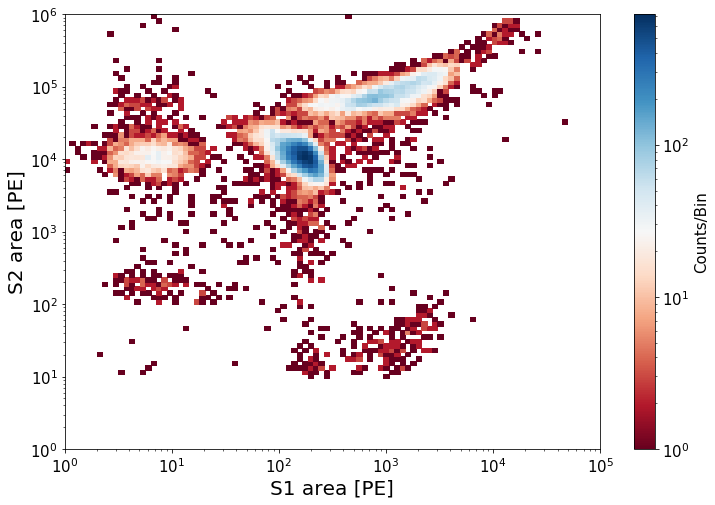

In [154]:
fig, ax = plt.subplots(figsize=(12,8))

bins_x = np.logspace(0,5,100)
bins_y = np.logspace(0,6,100)
histo_max= 2*10**3

counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, cmap='RdBu', norm=mcolors.LogNorm())
ax.set_xlabel('S1 area [PE]', fontsize = 20)
ax.set_ylabel('S2 area [PE]', fontsize = 20)

#ax.set_title(' xxx', fontsize= 15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label ='Counts/Bin', fontsize=15)

In [32]:
# plt.figure(figsize=(18,13))
# plt.hist(ncomp['n_competing'], bins=np.arange(20))
# plt.show()

[30.77 35.99 36.96 ... 35.73 31.5  35.44]


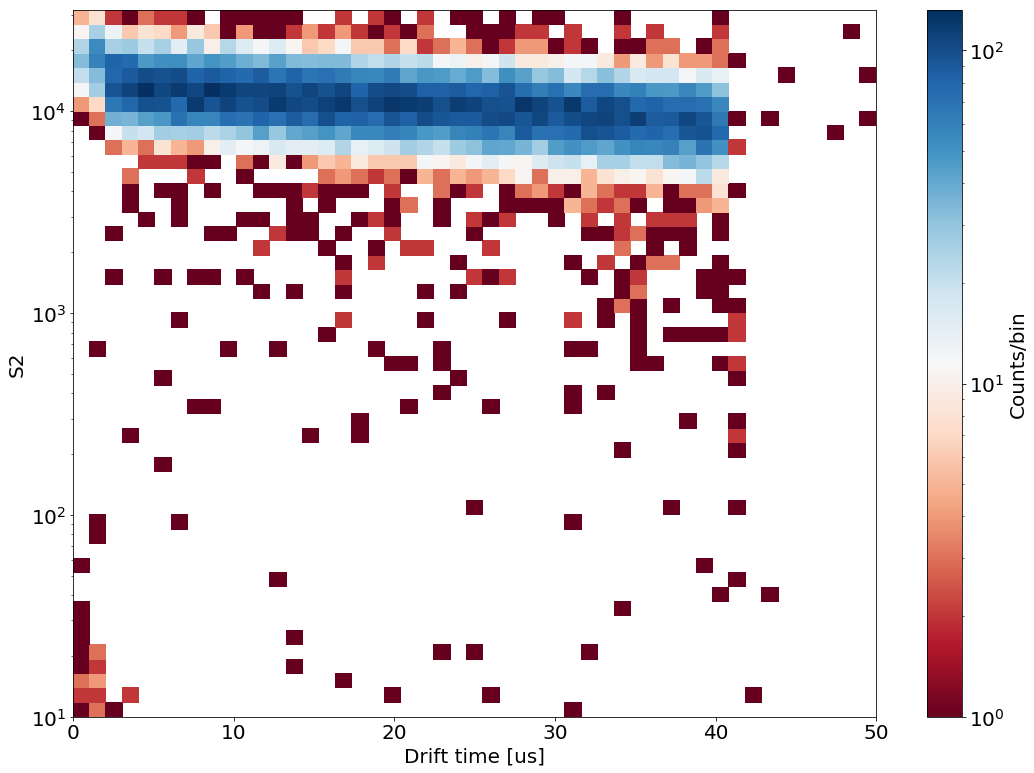

In [155]:
line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(1,4.5,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))
print(line['drift_time']/1e3)
im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
plt.colorbar(im,ax=ax, label='Counts/bin')
ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()

In [156]:
xcenter = ((xedges[:-1]+xedges[1:])/2)
ycenter = ((yedges[:-1]+yedges[1:])/2)
# print(xcenter)
# print(ycenter)

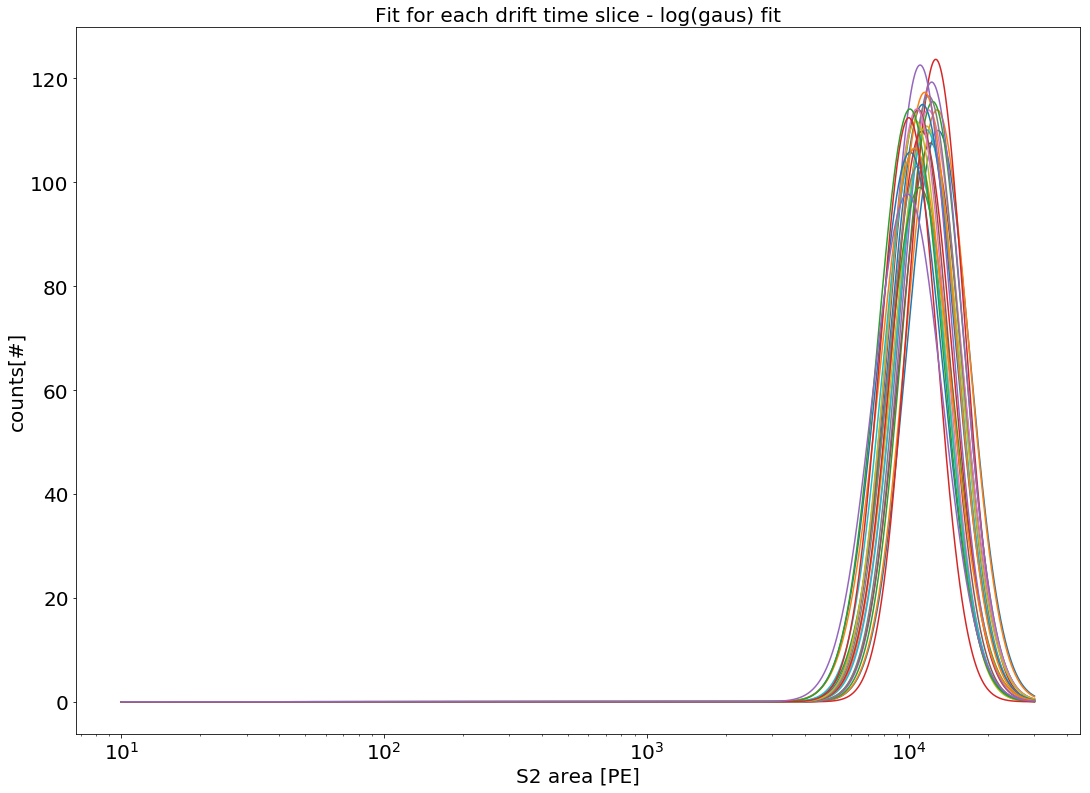

In [157]:
fig, ax = plt.subplots(figsize=(18,13))
fit_range= np.linspace(10,30000,1000)

def single_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus
p0 = [60,8,8]
mu_list = []
mu_error_list = []
# popt, pcov = curve_fit(single_gaus, ycenter, counts[27], p0)
# plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
# plt.plot(fit_range, single_gaus(fit_range, *popt))
ax.set_xscale('log')
ax.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
ax.set_xlabel('S2 area [PE]', fontsize = 20)
ax.set_ylabel('counts[#]', fontsize = 20)
for i in range(5,30):   
    popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0)
    plt.plot(fit_range, single_gaus(fit_range, *popt))
    #value = np.exp(popt[1])
    value = np.exp(popt[1]+((popt[2]**2)/2))
    mu_list.append(value)
    perr = np.sqrt(np.diag(pcov))
    error_ln_mu = perr[1]
    error_mu = np.exp(popt[1])*error_ln_mu
    mu_error_list.append(error_mu)


plt.show()




In [36]:
print(counts[30])


[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   1.   0.   2.
   0.   0.   0.   1.   0.   0.   0.   5.   1.  10.  20.  50.  77. 100.
 120.  55.  18.  12.   2.   2.   0.]


this is lamba:  0.010313703641732494
this is 1/lamba:  96.95838030033023
electron lifetime:  67.21 +/- 39.79


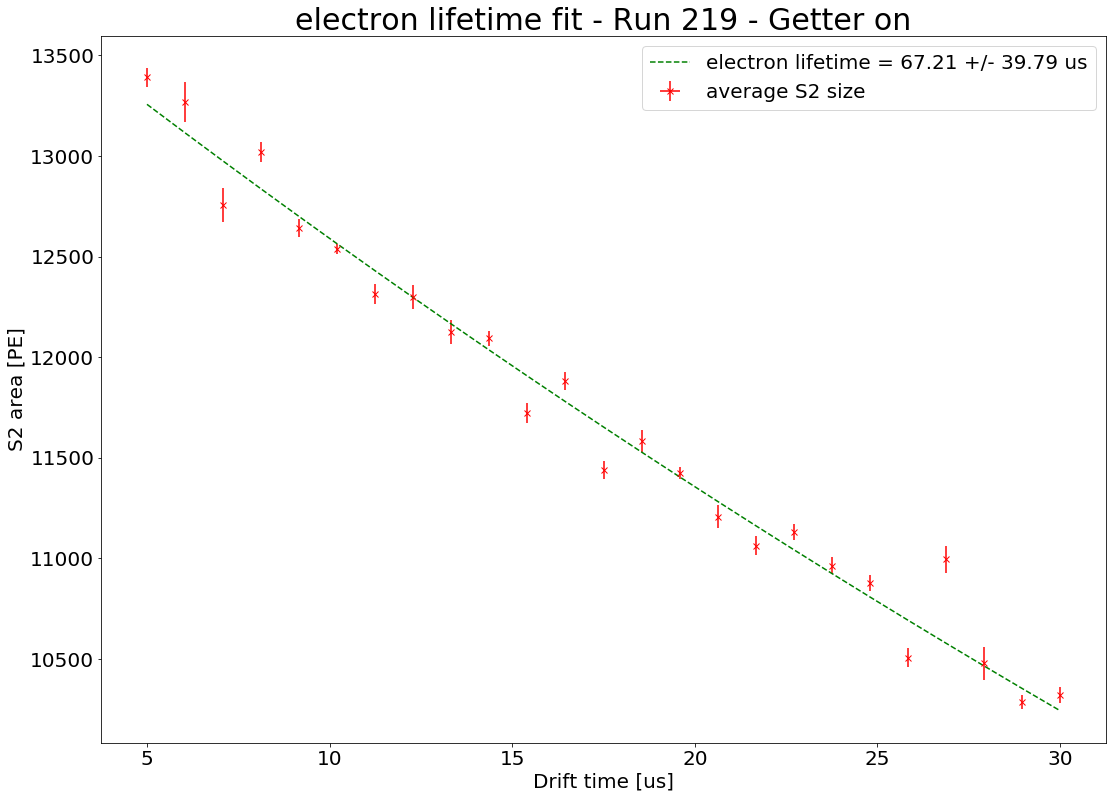

In [158]:
def expo(x, a, b):
    return a*np.exp(-b*x)

fig, ax =plt.subplots(figsize = (18,13))
p0=  [10000,0.1]
x = np.linspace(5,30,25)
y_values = mu_list
y_error = mu_error_list
SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)

popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
# lifetime = 1/popt[1]
# lifetime_error = (1/(popt[1]**2))*perr[1]
lifetime = "%.2f" % (1/popt[1]*np.log(2))
lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])

plt.errorbar(x, y_values, yerr=y_error, xerr=0, fmt = 'rx', label = 'average S2 size' )

print('this is lamba: ', popt[1])
print('this is 1/lamba: ', 1/popt[1] )
plt.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
# print(y_error)


#ax.set_ylim([130,250])
ax.set_title('electron lifetime fit - Run '+run[2:]+' - Getter on')
ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2 area [PE]')


print('electron lifetime: ', lifetime, '+/-', lifetime_error)

# print(perr)
plt.legend(prop={'size': 20})
plt.show()


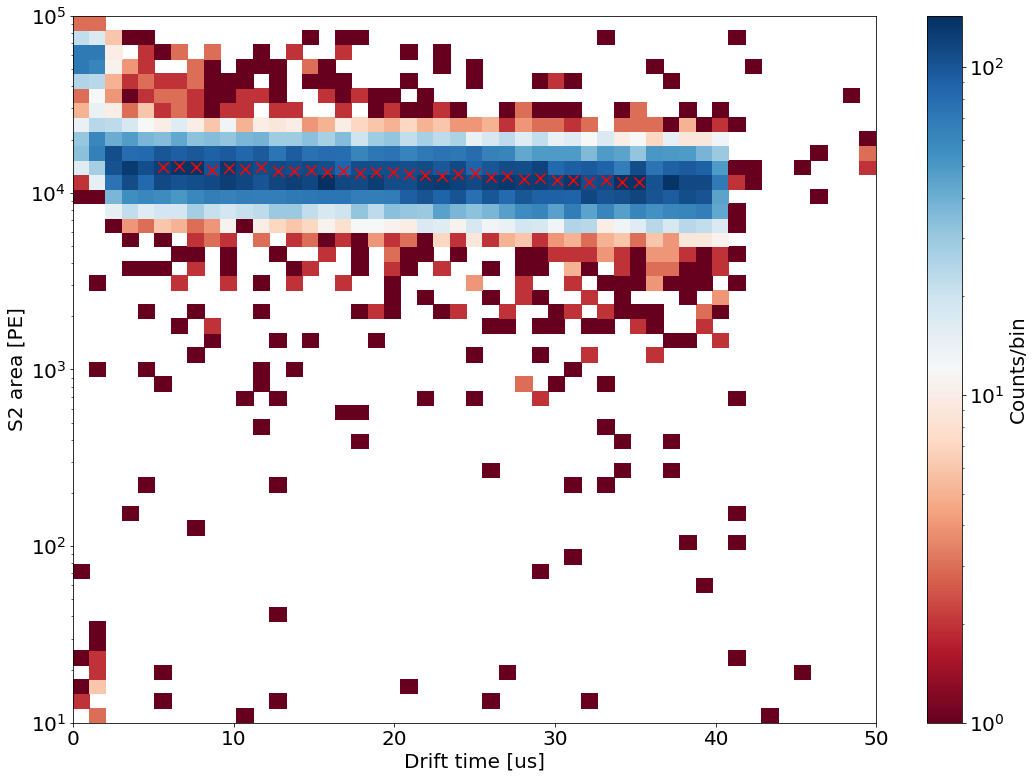

In [130]:
line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(1,5,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
plt.colorbar(im,ax=ax, label='Counts/bin')

plt.scatter(xcenter[5:35], y_values, c = 'r', marker = 'x', s =110)

ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2 area [PE]')
plt.show()

In [ ]:
# line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
# fig, ax = plt.subplots(figsize=(18,13))

# bins_x = np.linspace(0,50,50)
# #bins_y = np.logspace(1,3.5,50)
# counts, binEdges = np.histogram(line['drift_time']/1e3, bins=bins_x)

# #ax.set_yscale('log')
# plt.hist(line['drift_time']/1e3, bins=bins_x, color='C5')
# ax.set_xlabel('Drift time [us]')
# ax.set_ylabel('S2')
# plt.show()

In [ ]:
eval('1'+'+2')

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra

In [2]:
ctx = straxbra.XebraContext()

/software/straxbra/straxbra/plugins.py:372: RuntimeWarning: invalid value encountered in true_divide
  return LRF_PMTs_array / (np.sum(LRF_PMTs_array))
/software/straxbra/straxbra/plugins.py:377: RuntimeWarning: divide by zero encountered in true_divide
  reconstruct = lambda x: np.sum(((self.LRF_PMTs(x[0], x[1]) - HFs_input)**2) / (self.LRF_PMTs(x[0], x[1])))
/software/straxbra/straxbra/plugins.py:377: RuntimeWarning: invalid value encountered in true_divide
  reconstruct = lambda x: np.sum(((self.LRF_PMTs(x[0], x[1]) - HFs_input)**2) / (self.LRF_PMTs(x[0], x[1])))


[ 4.63 12.   32.29 ... 20.35 40.02  0.  ]
this is lamba:  0.00608235989909323
this is 1/lamba:  164.40986995016226
electron lifetime:  113.96 +/- 174.68


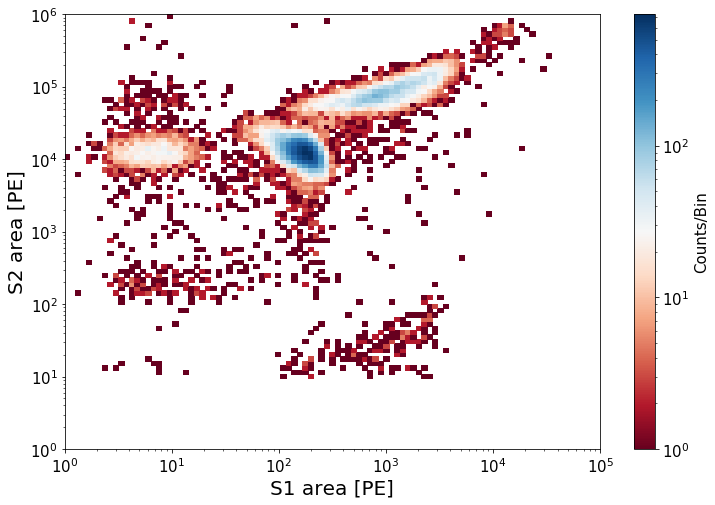

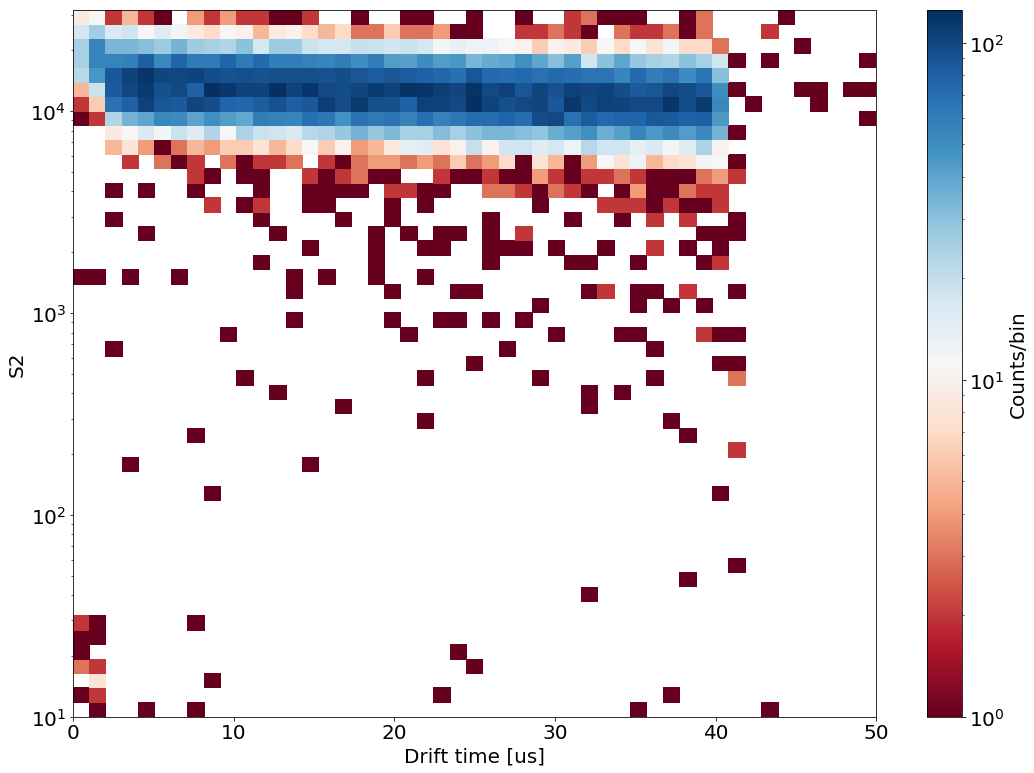

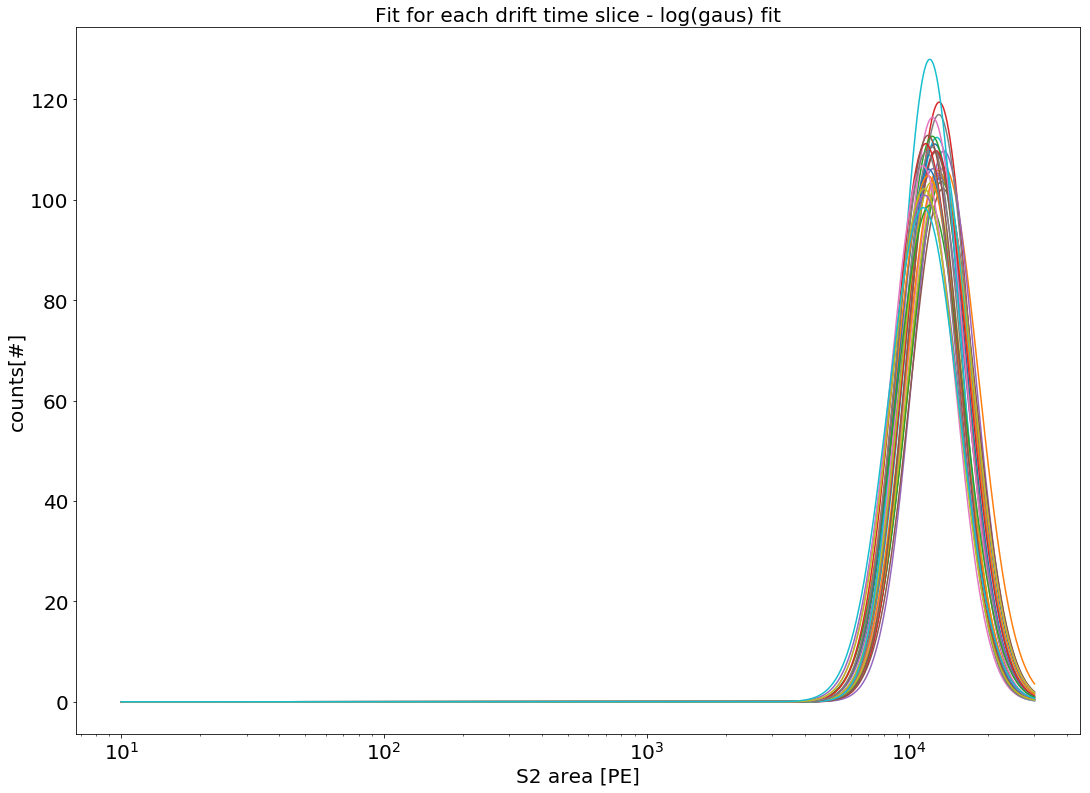

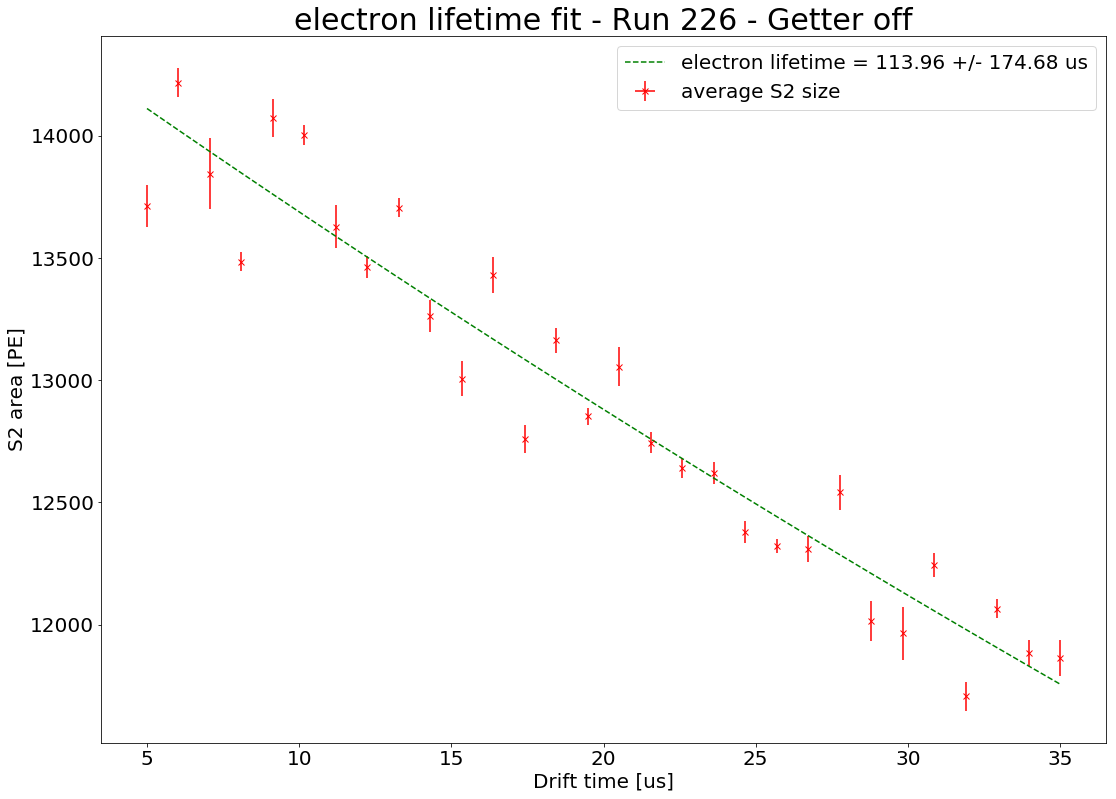

[ 0.   20.66  1.2  ... 34.89  8.91  0.  ]
this is lamba:  0.006852173487702067
this is 1/lamba:  145.93909535343045
electron lifetime:  101.16 +/- 87.45


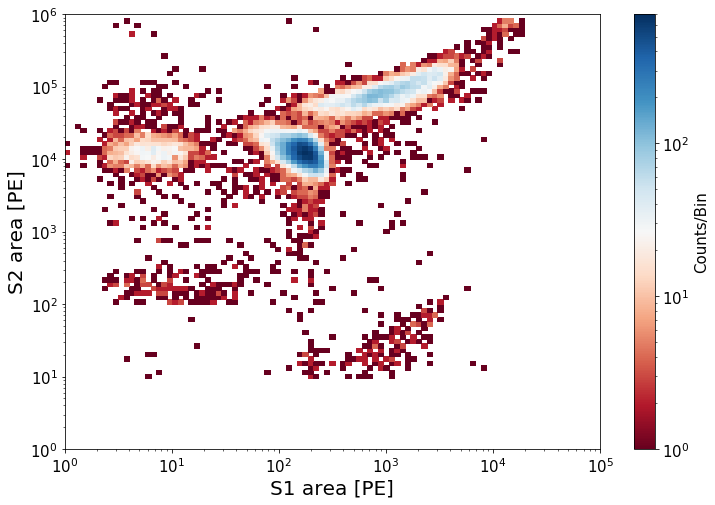

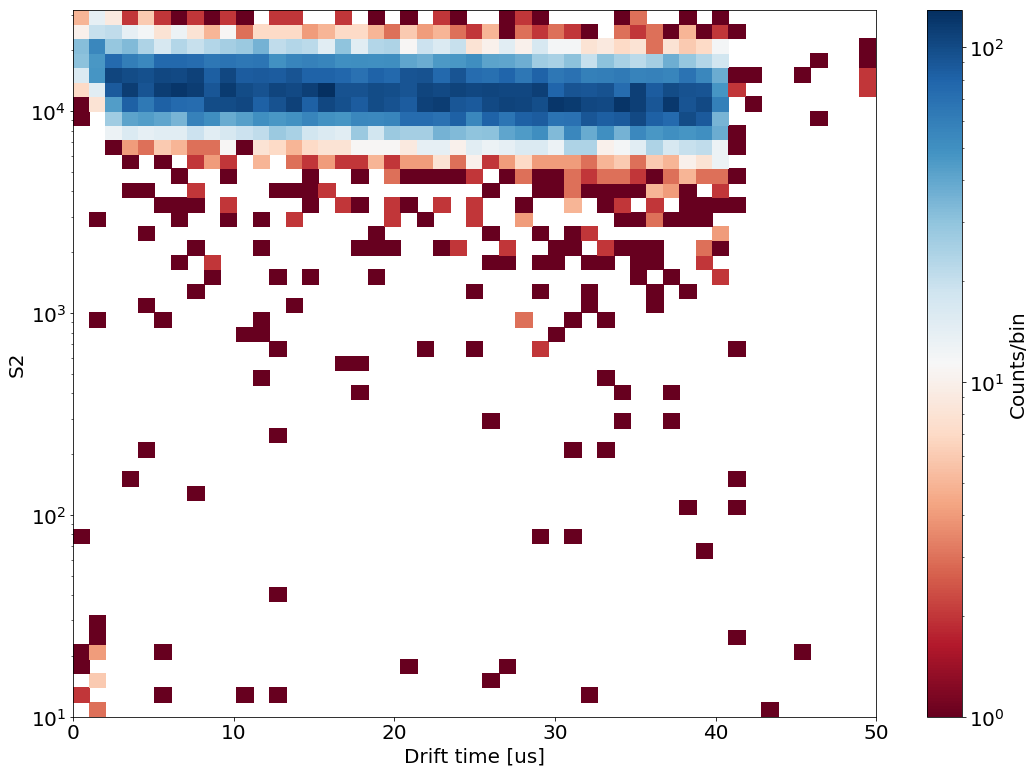

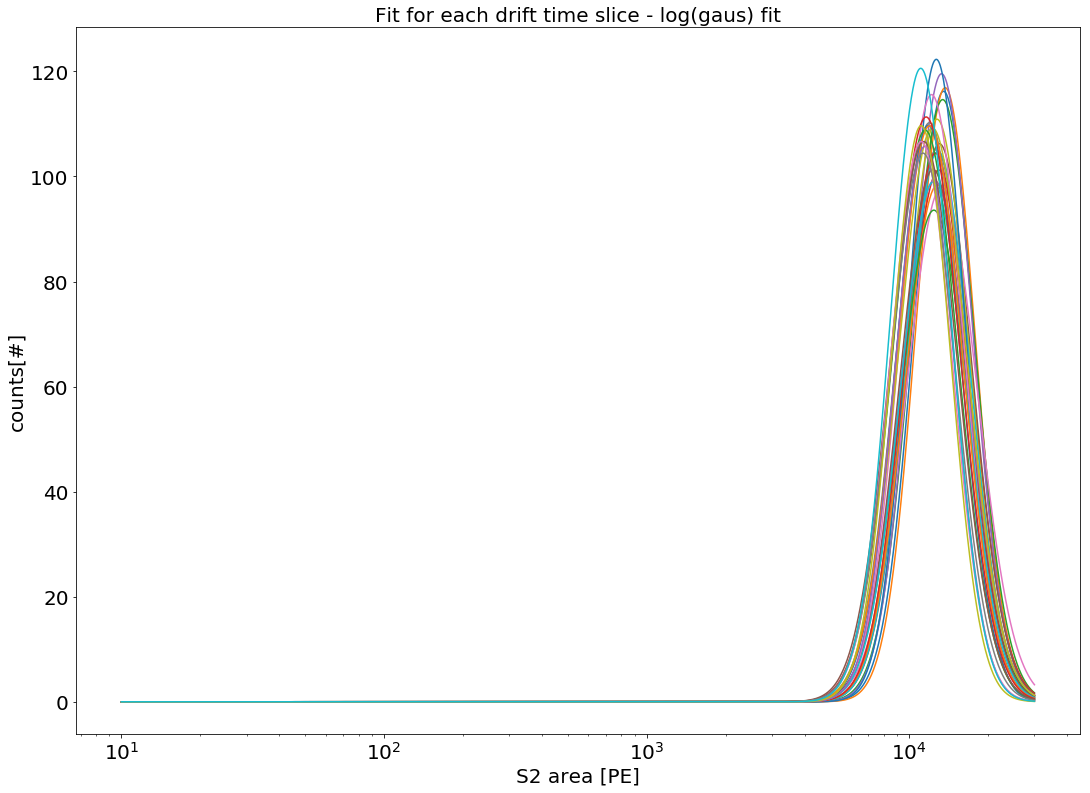

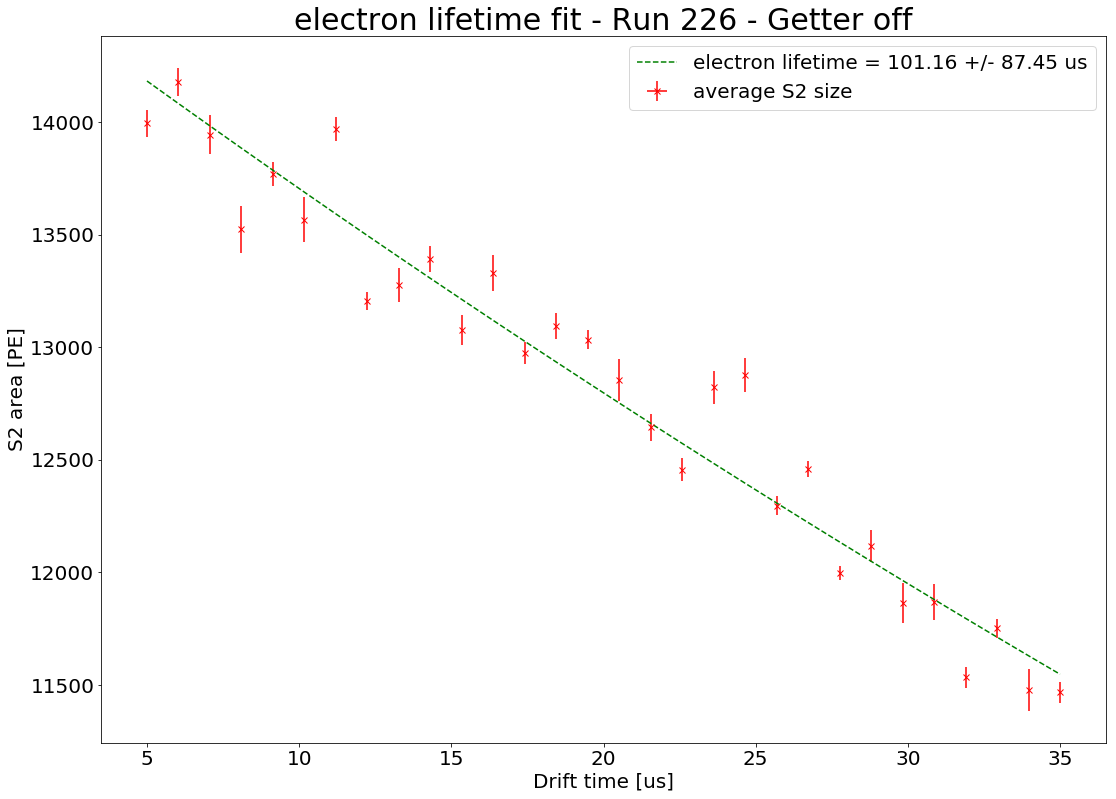

[30.77 35.99 36.96 ... 35.73 31.5  35.44]
this is lamba:  0.010409507764720272
this is 1/lamba:  96.06602181413257
electron lifetime:  66.59 +/- 68.37


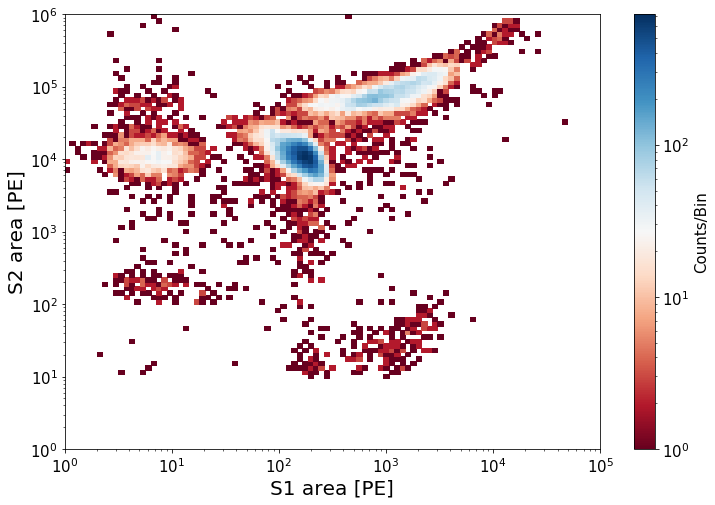

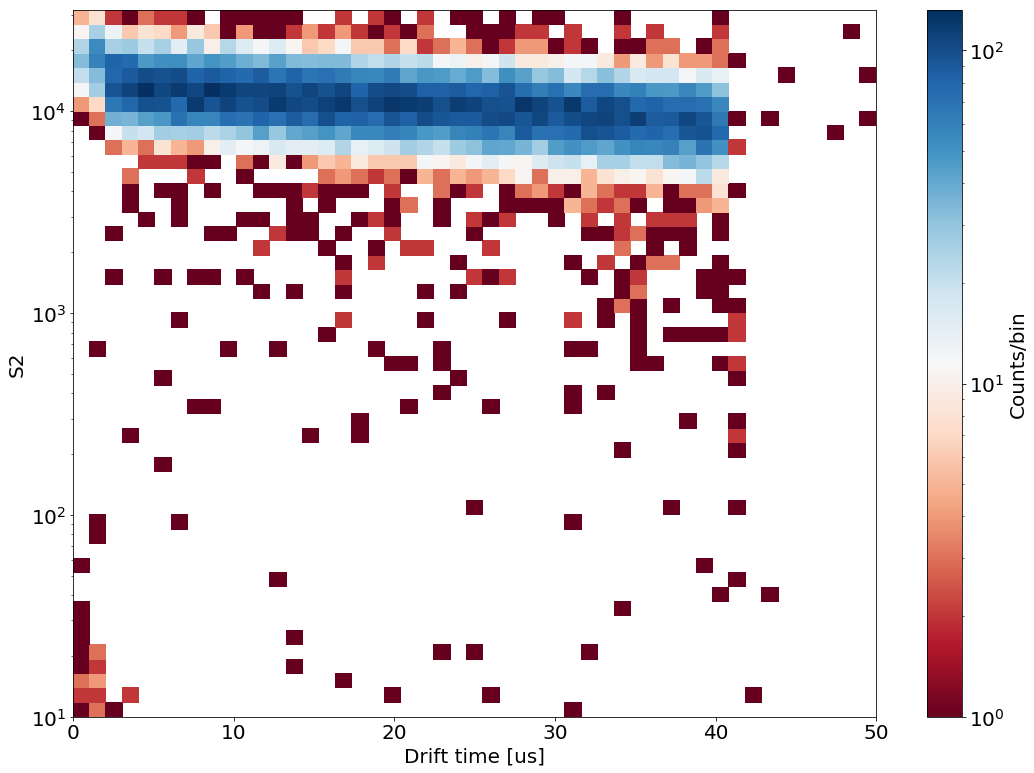

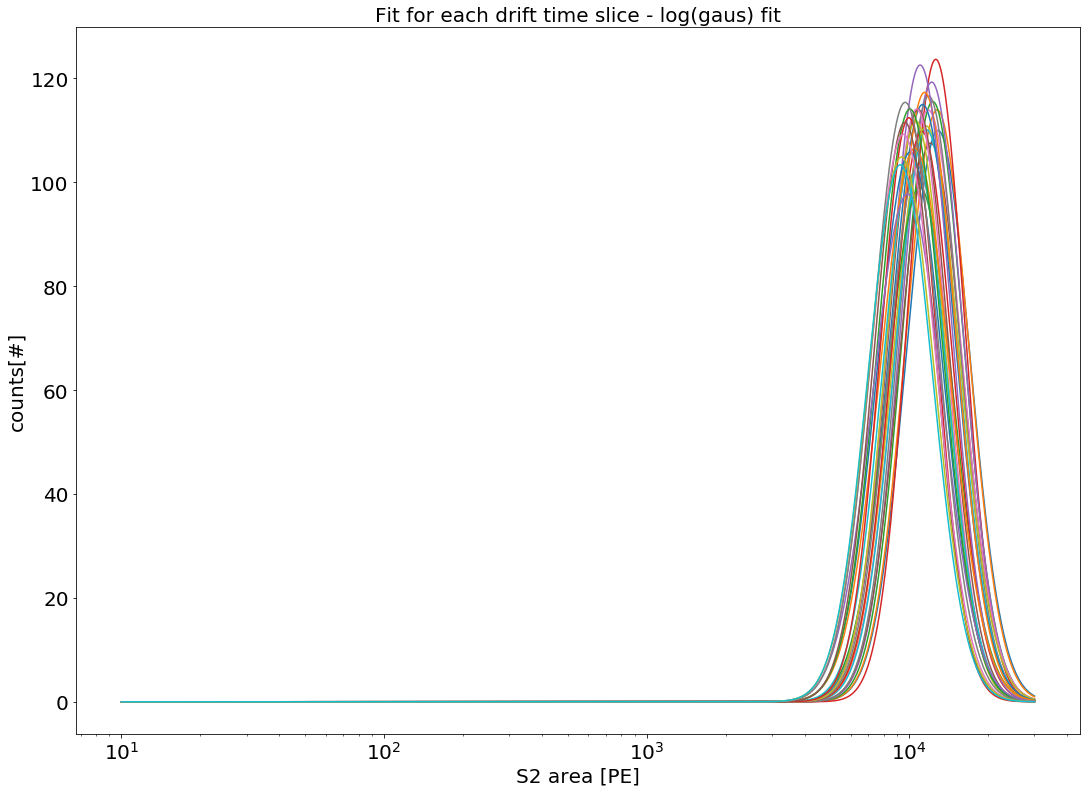

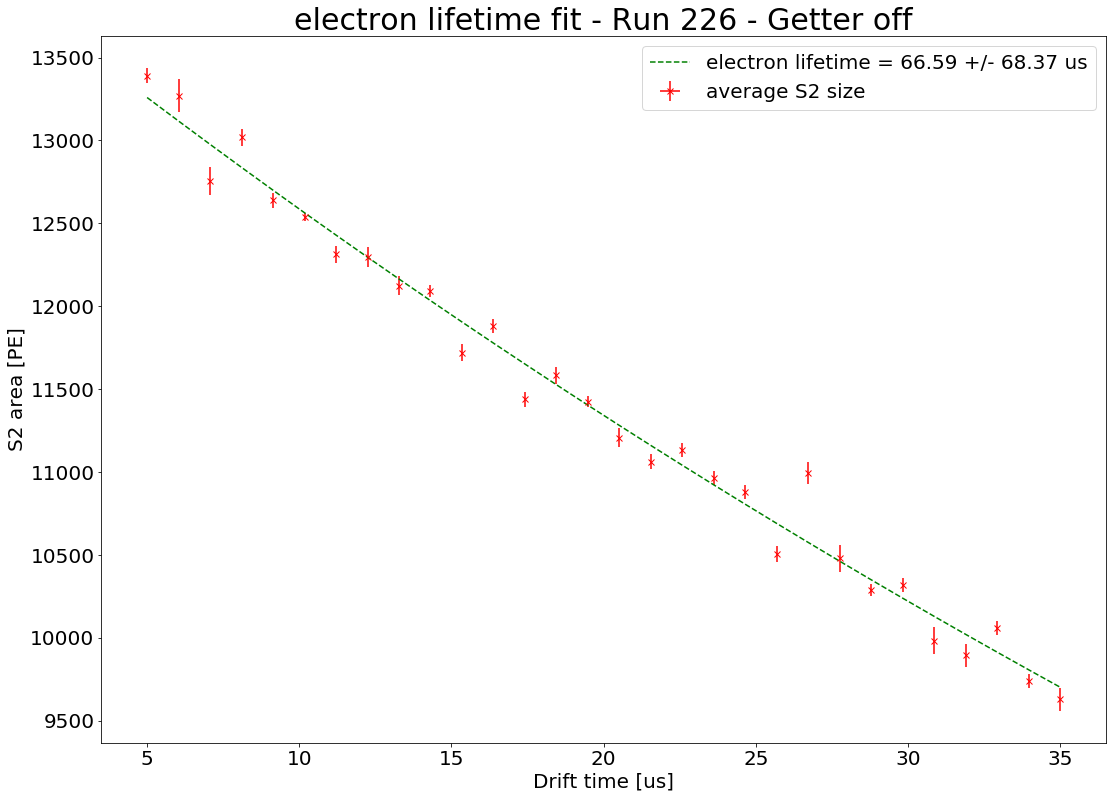

[ 0.    0.    0.   ...  0.95  0.   36.84]
this is lamba:  0.021170697062955764
this is 1/lamba:  47.23510033827787
electron lifetime:  32.74 +/- 11.00


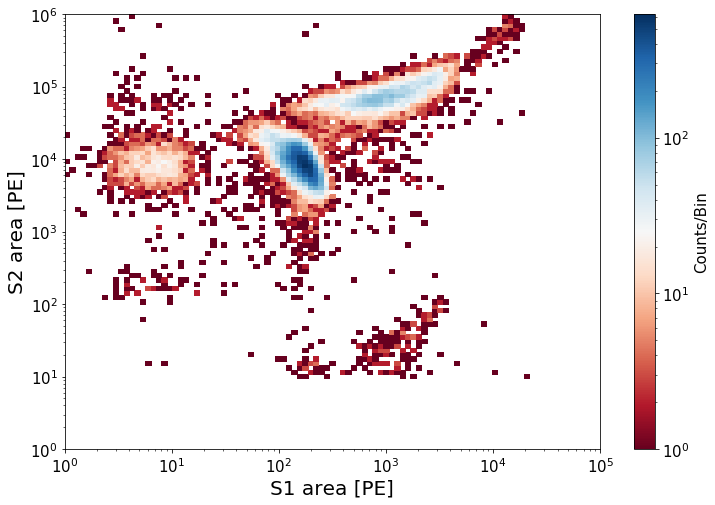

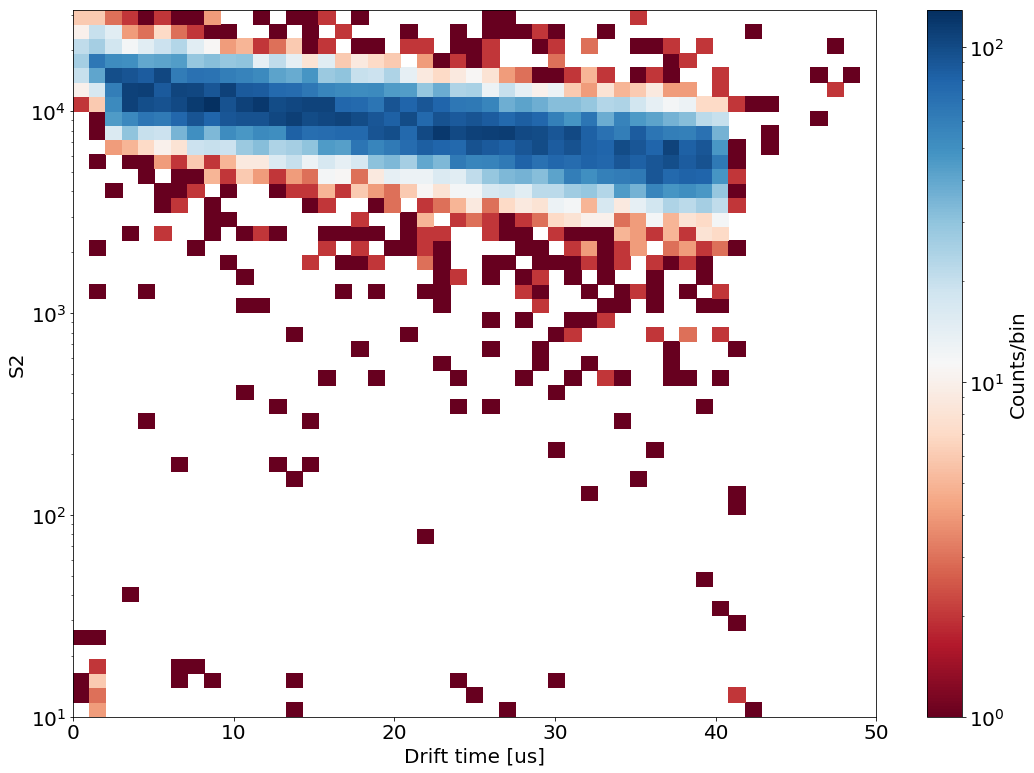

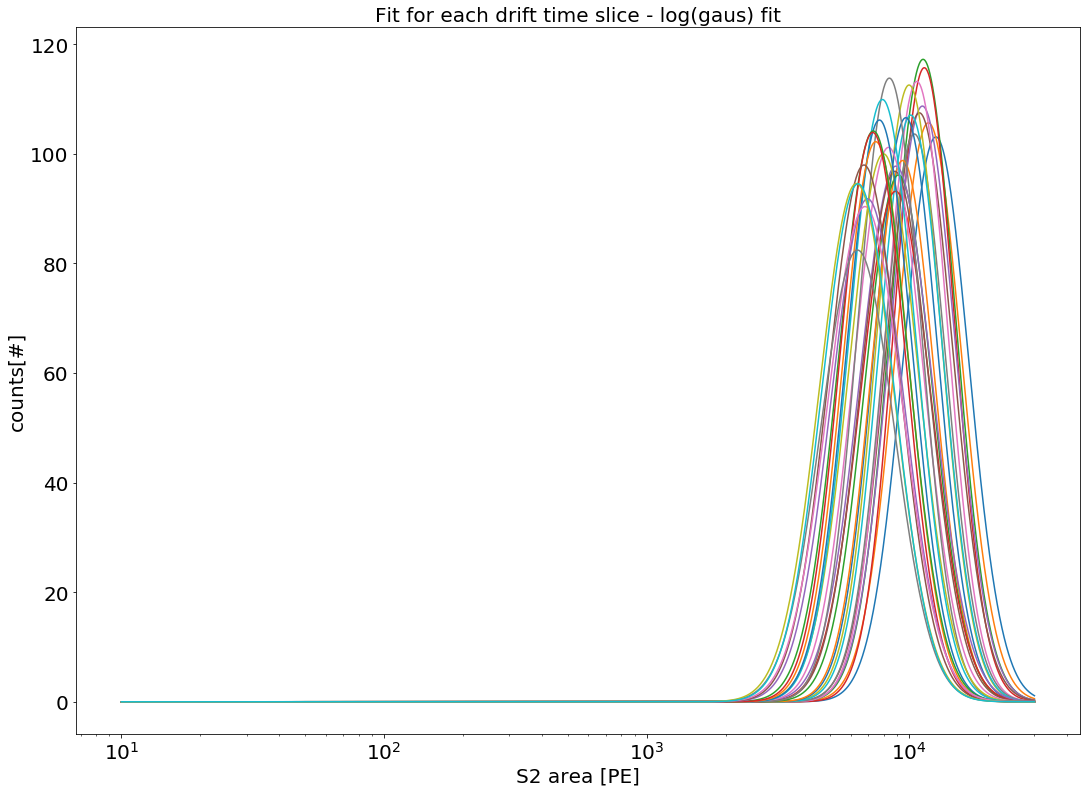

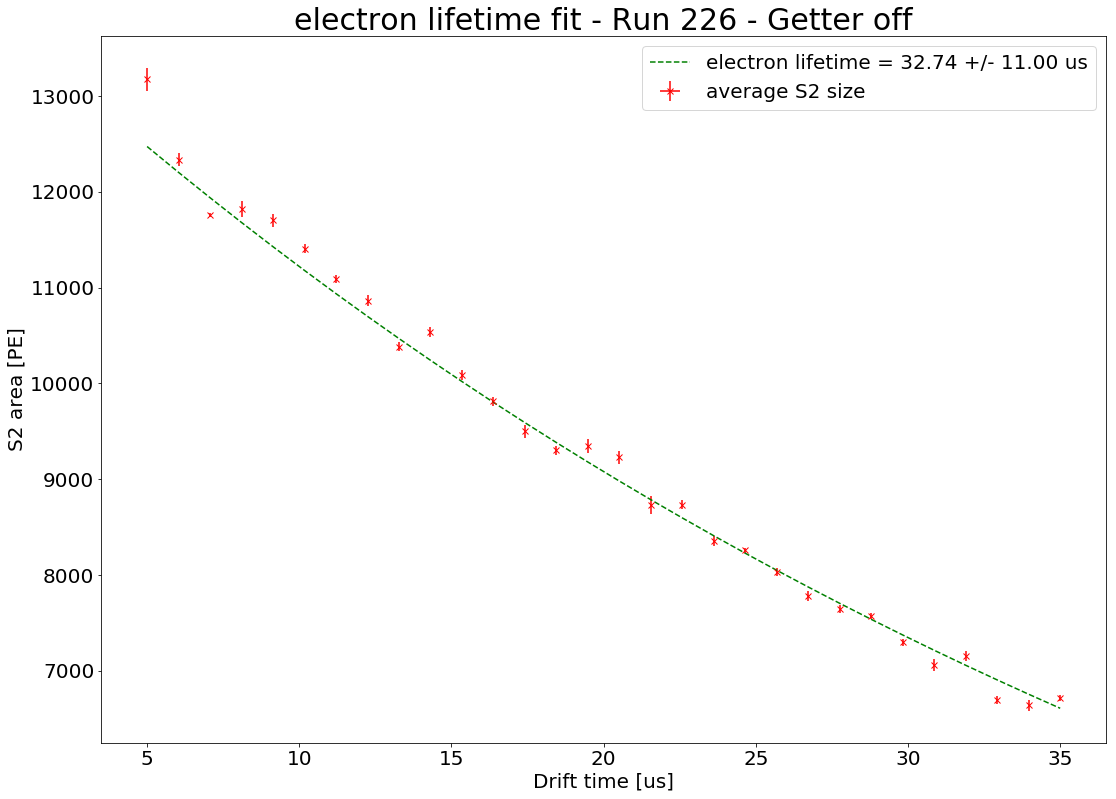

[ 0.   13.11 10.38 ...  0.   28.68  0.  ]
this is lamba:  0.03328849737241597
this is 1/lamba:  30.04040671504252
electron lifetime:  20.82 +/- 14.27


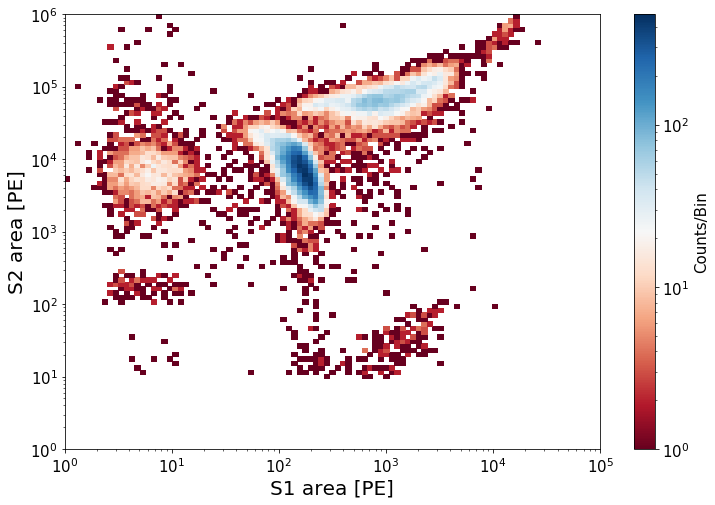

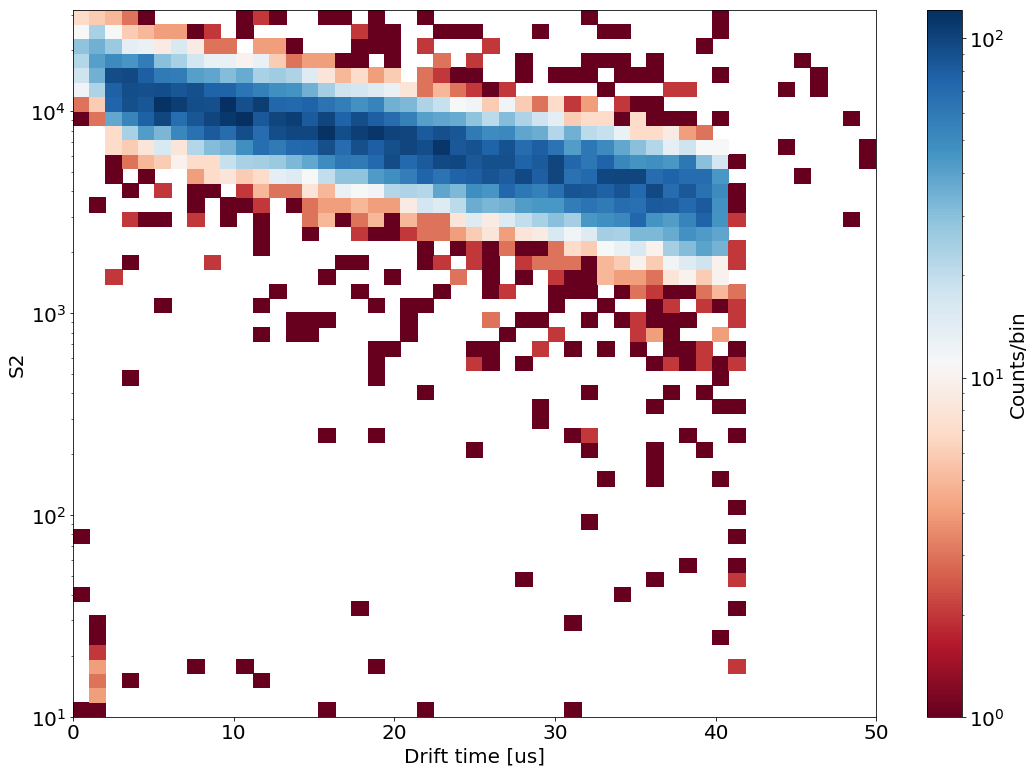

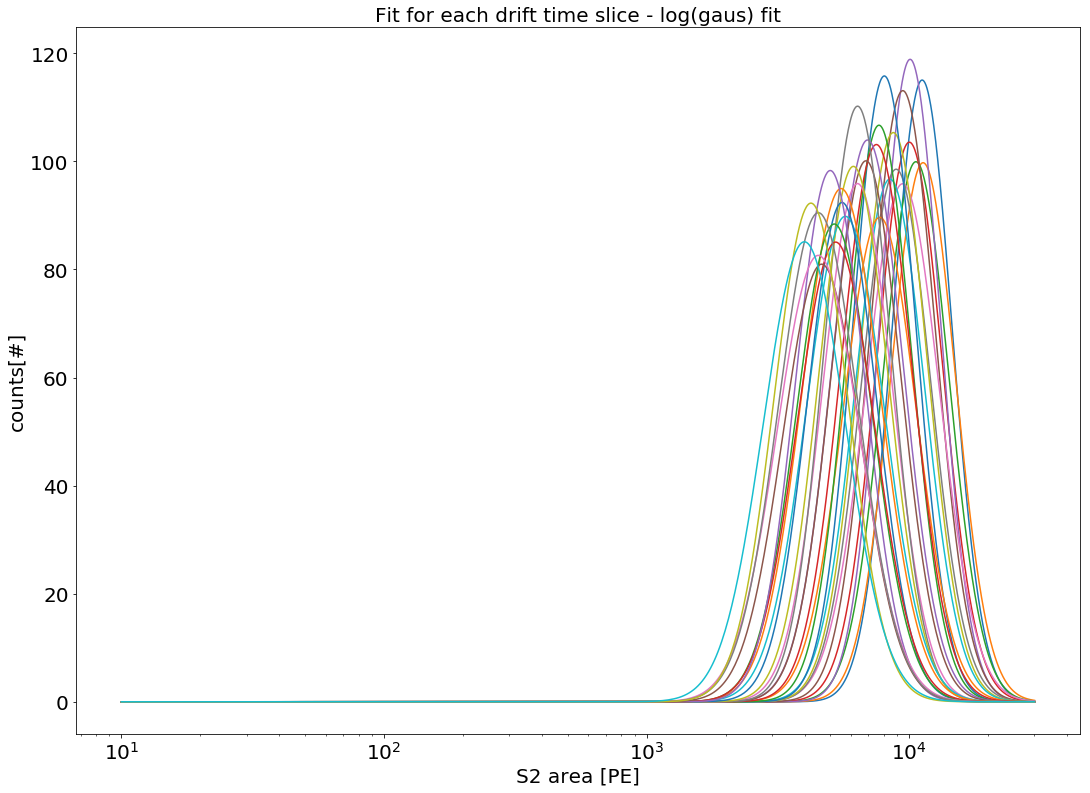

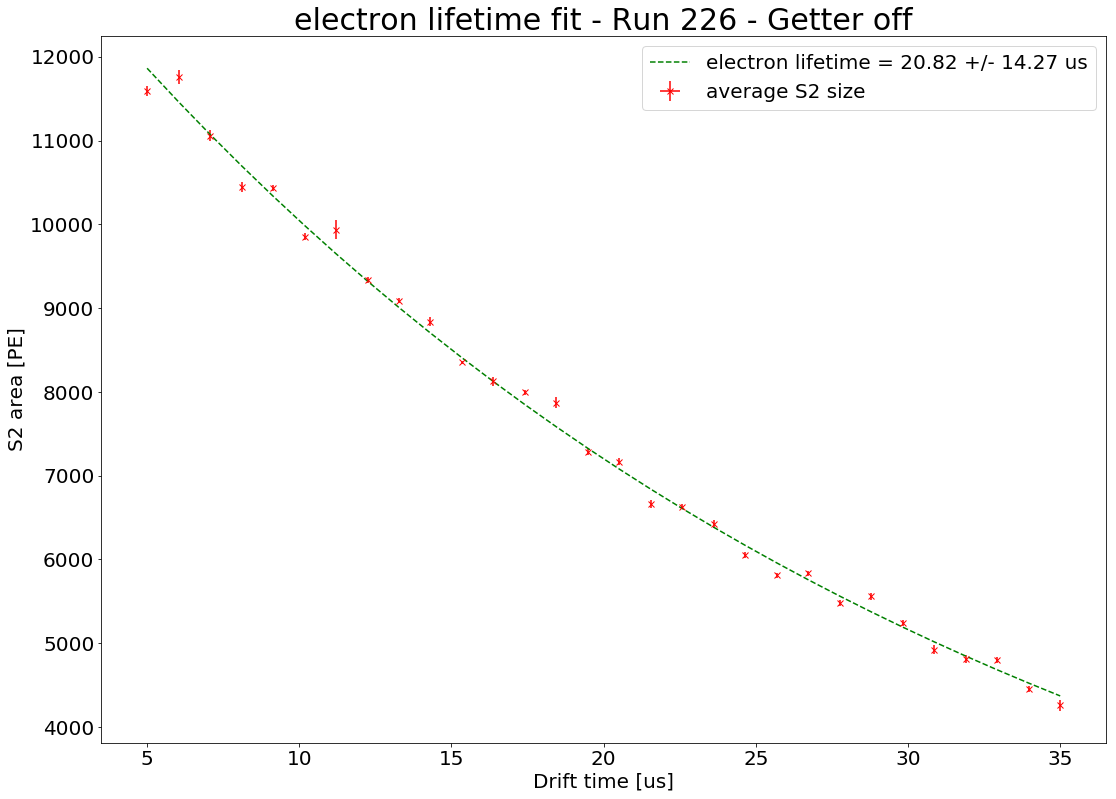

[ 9.19 28.28 14.53 ... 28.74 34.23 18.92]
this is lamba:  0.04640002360537181
this is 1/lamba:  21.551713173788738
electron lifetime:  14.94 +/- 6.87


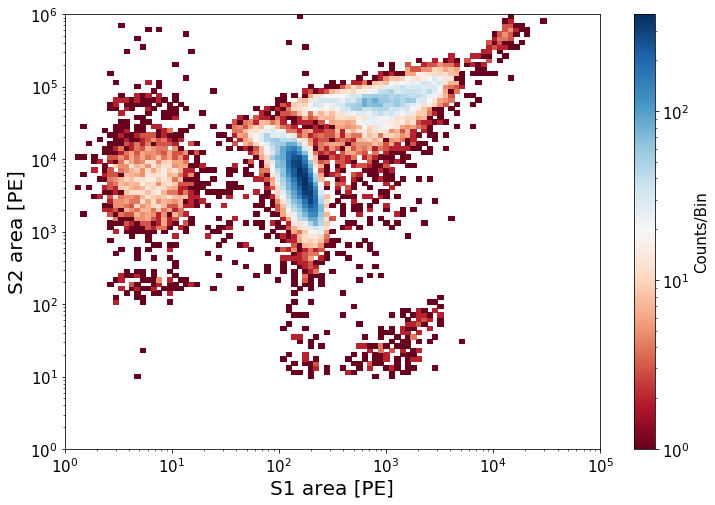

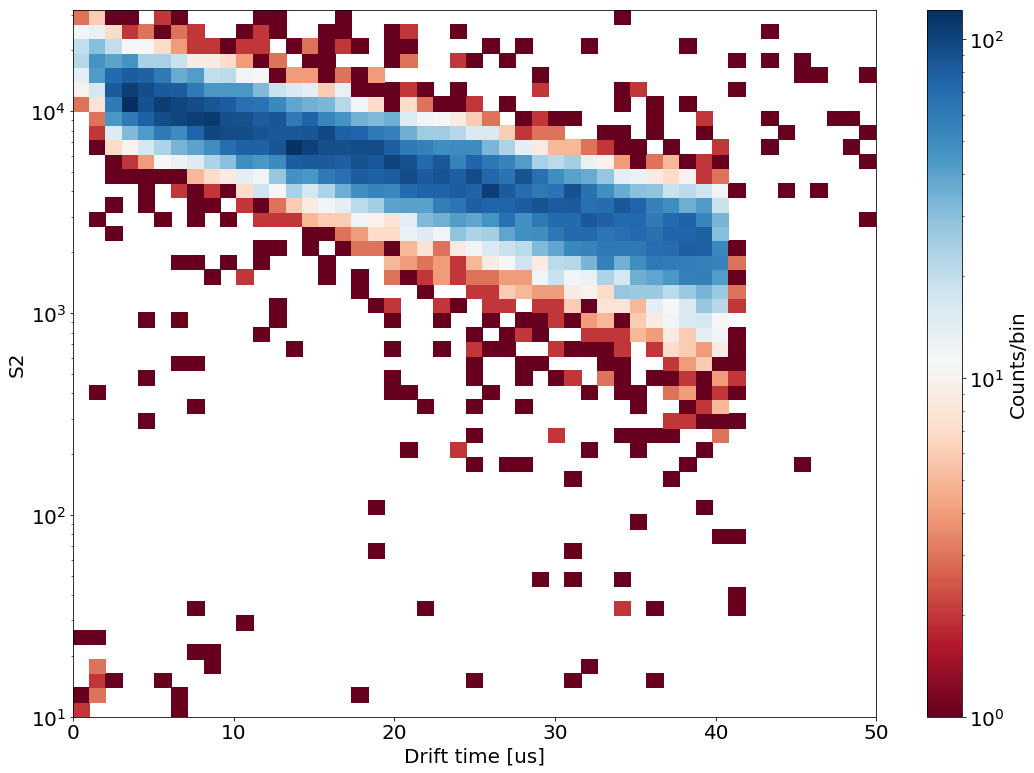

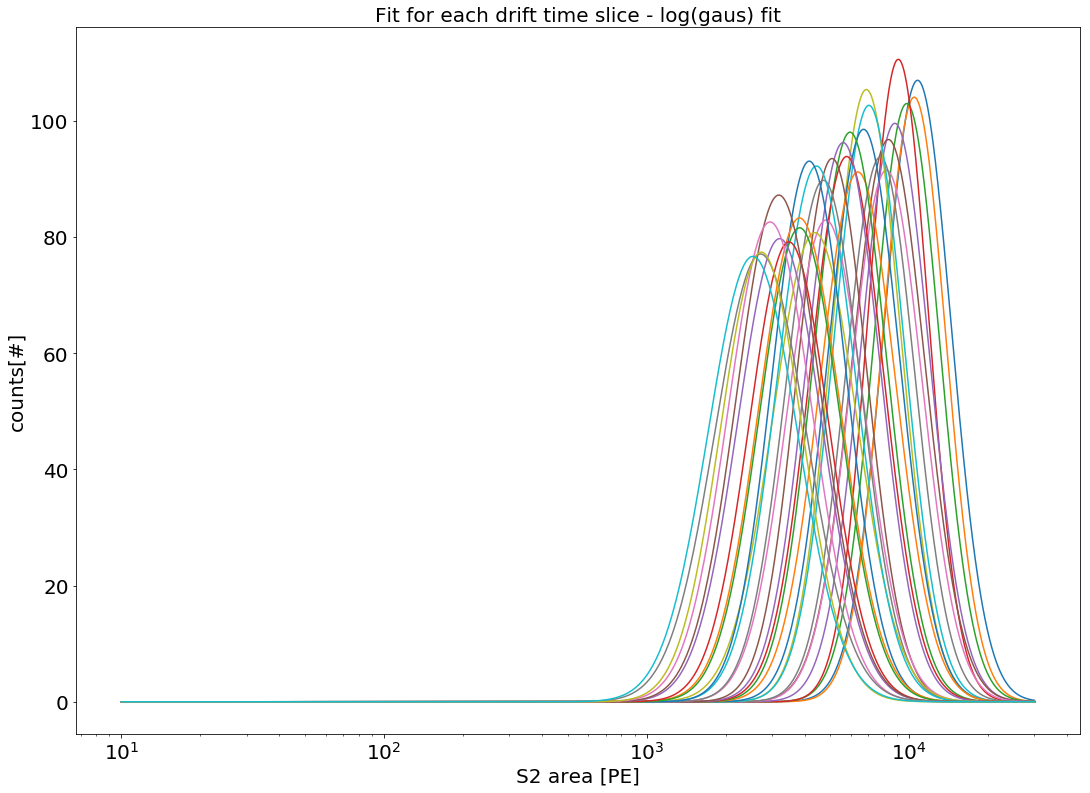

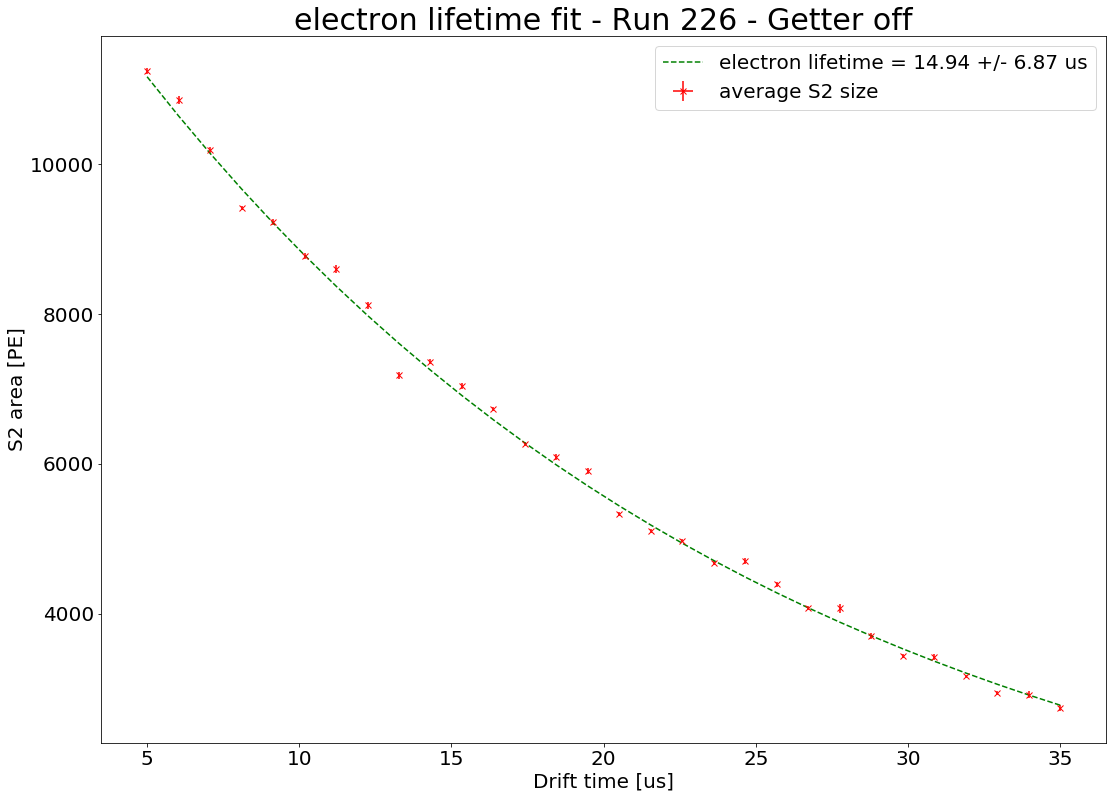

[ 0.   10.03 27.87 ...  0.   16.86  8.91]
this is lamba:  0.06086674554888757
this is 1/lamba:  16.42933248660075
electron lifetime:  11.39 +/- 3.34


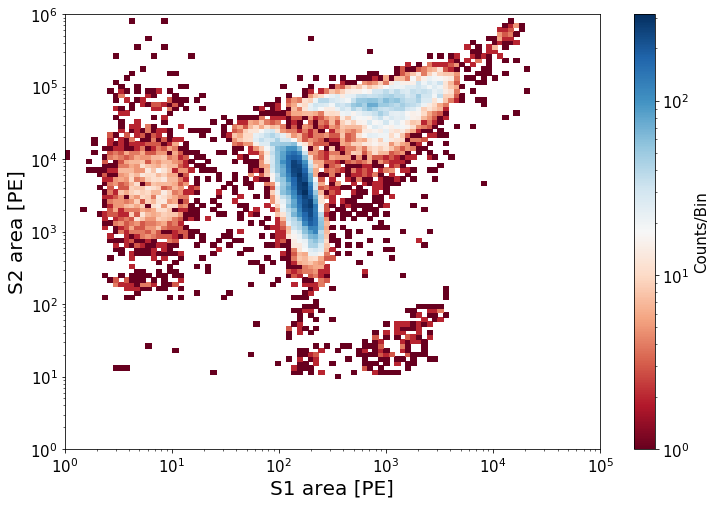

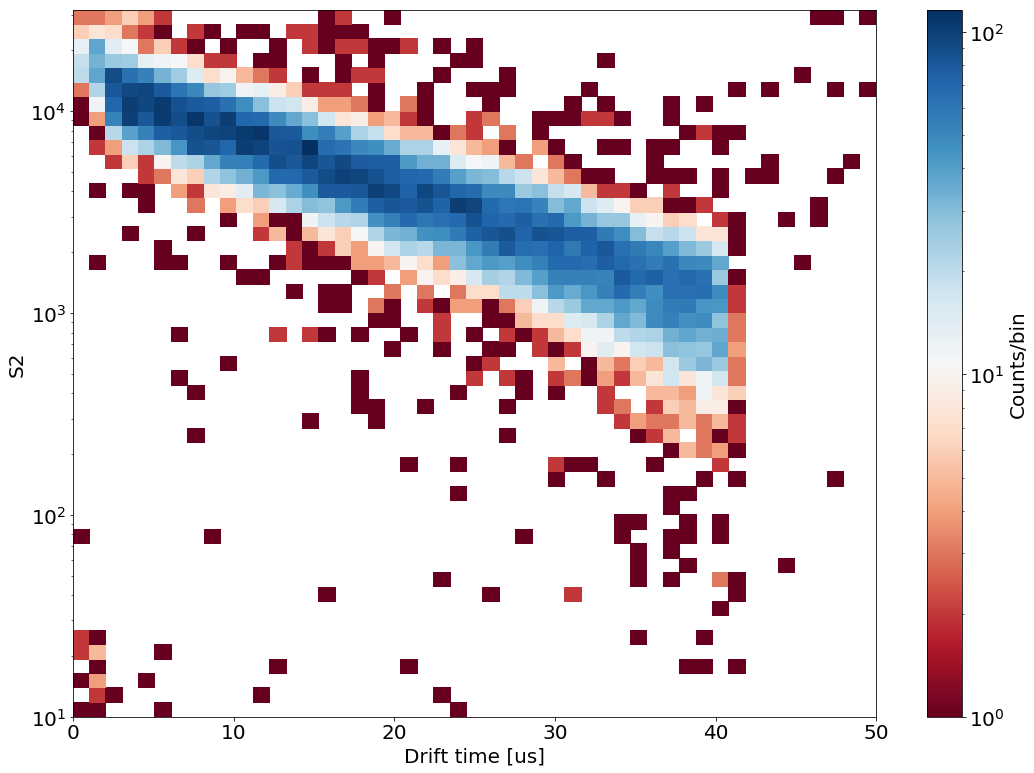

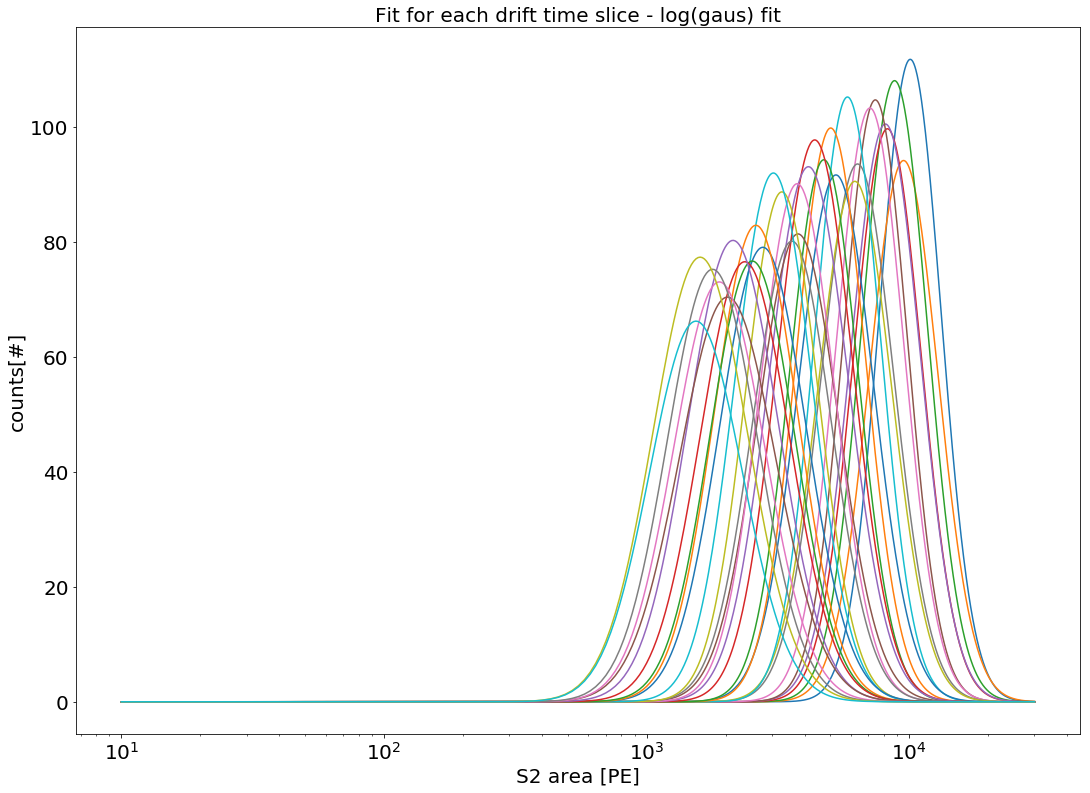

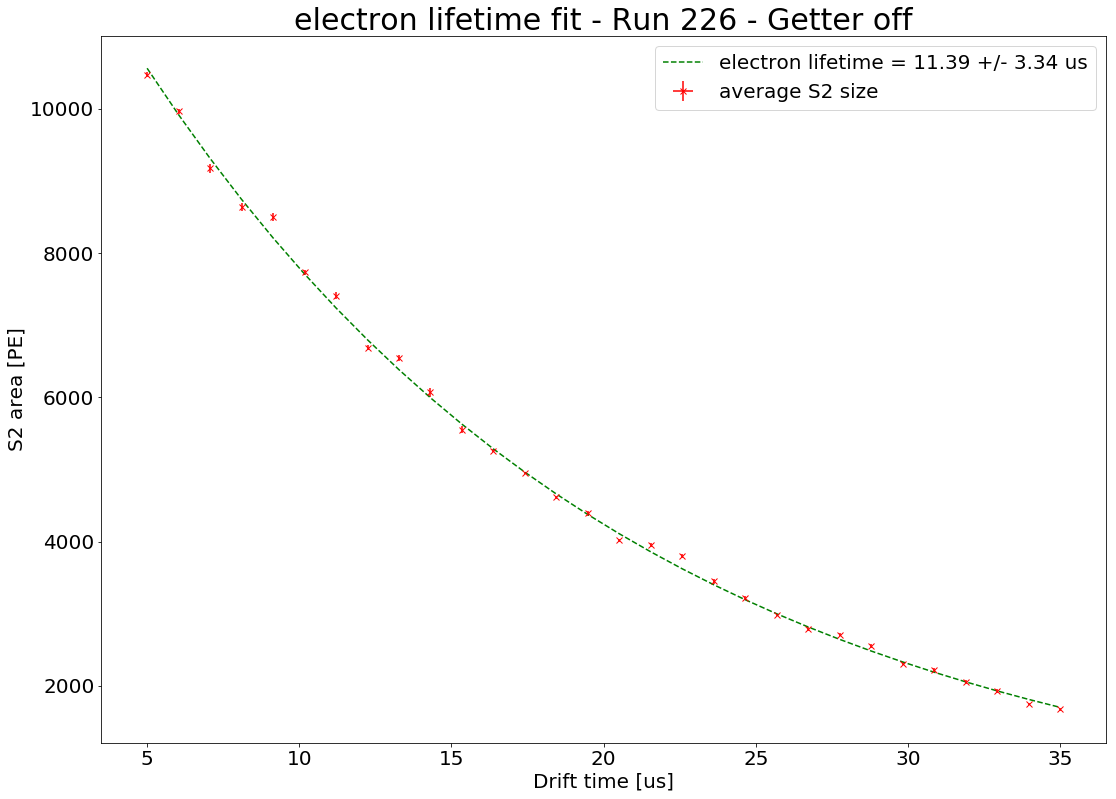

[ 0.   30.82 10.01 ... 13.88  3.82  0.  ]
this is lamba:  0.07868049384877894
this is 1/lamba:  12.70963044438897
electron lifetime:  8.81 +/- 1.92


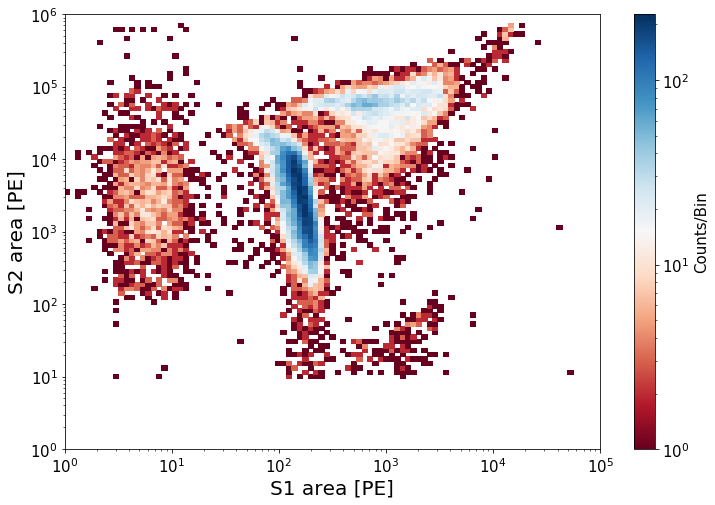

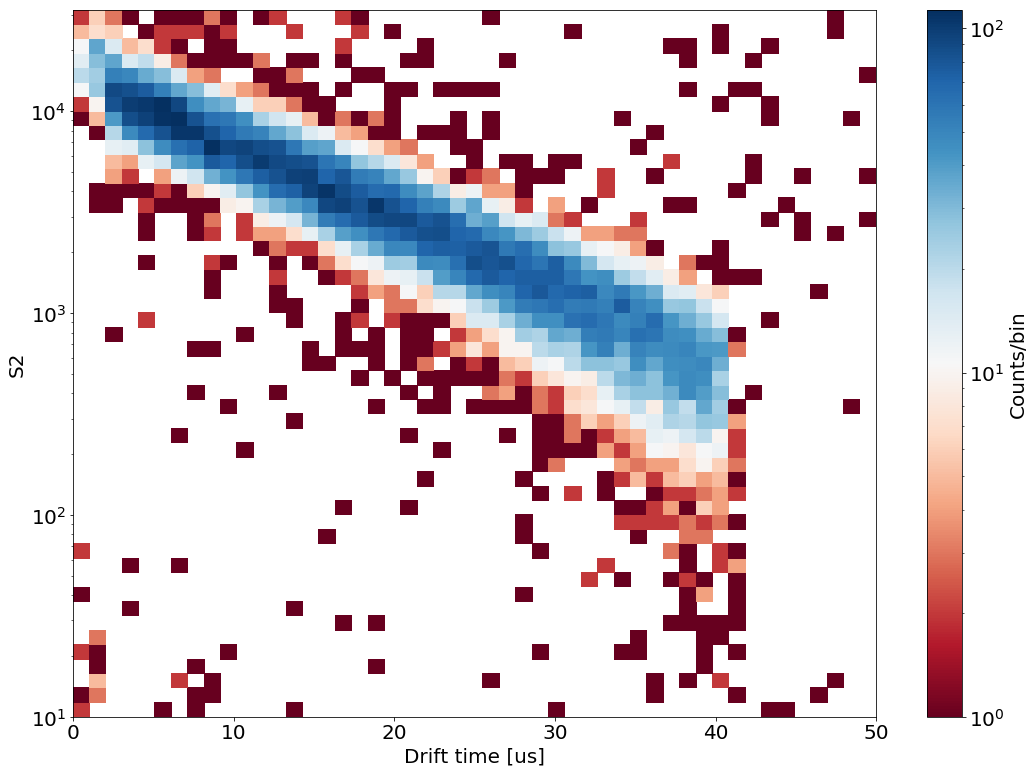

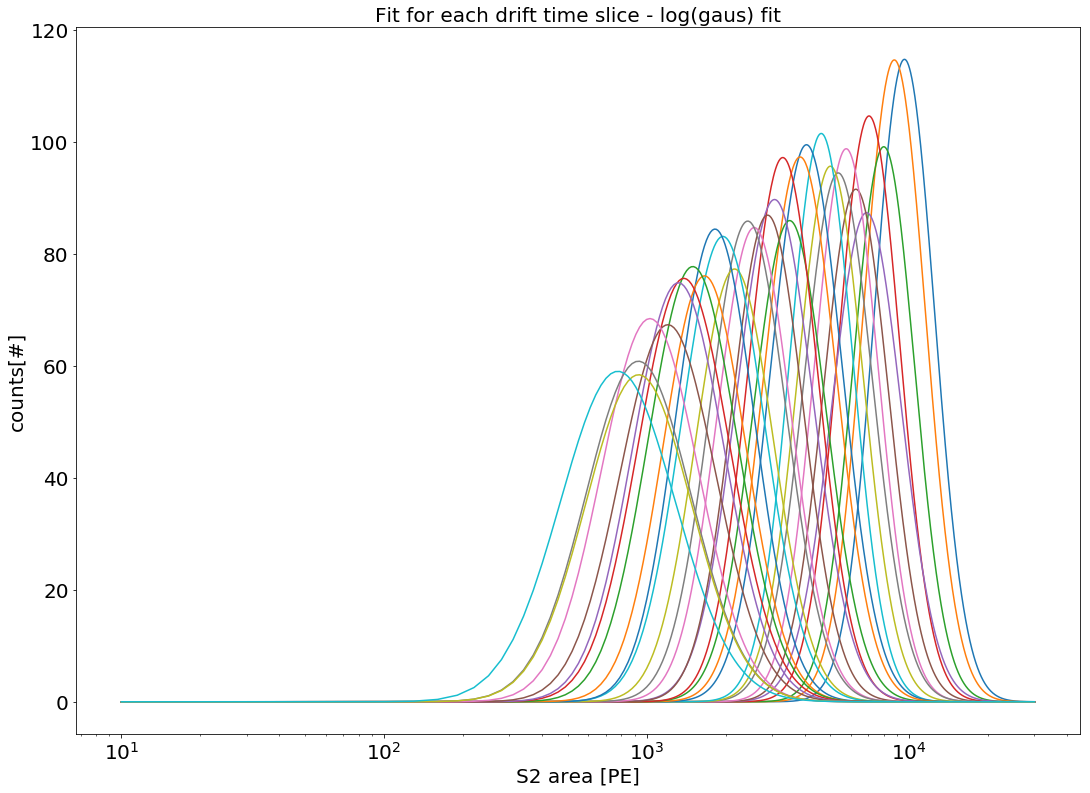

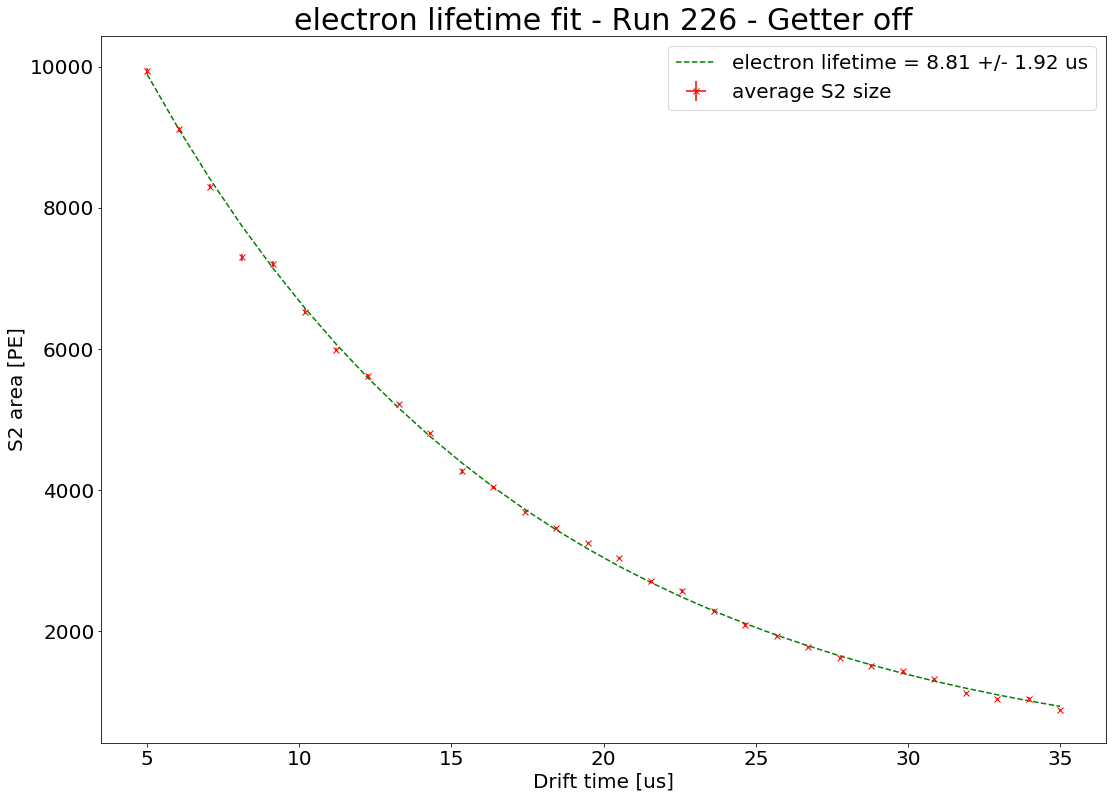

[22.35  0.   31.27 ... 21.96 27.38  0.  ]
this is lamba:  0.09332635120151346
this is 1/lamba:  10.715087294485196
electron lifetime:  7.43 +/- 2.50


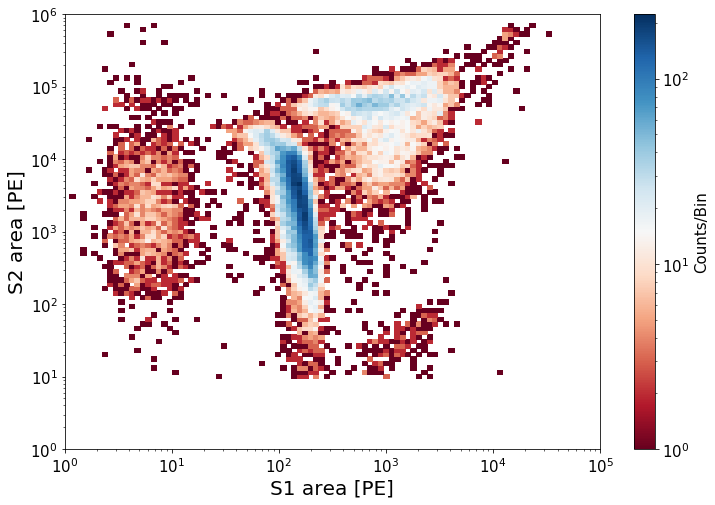

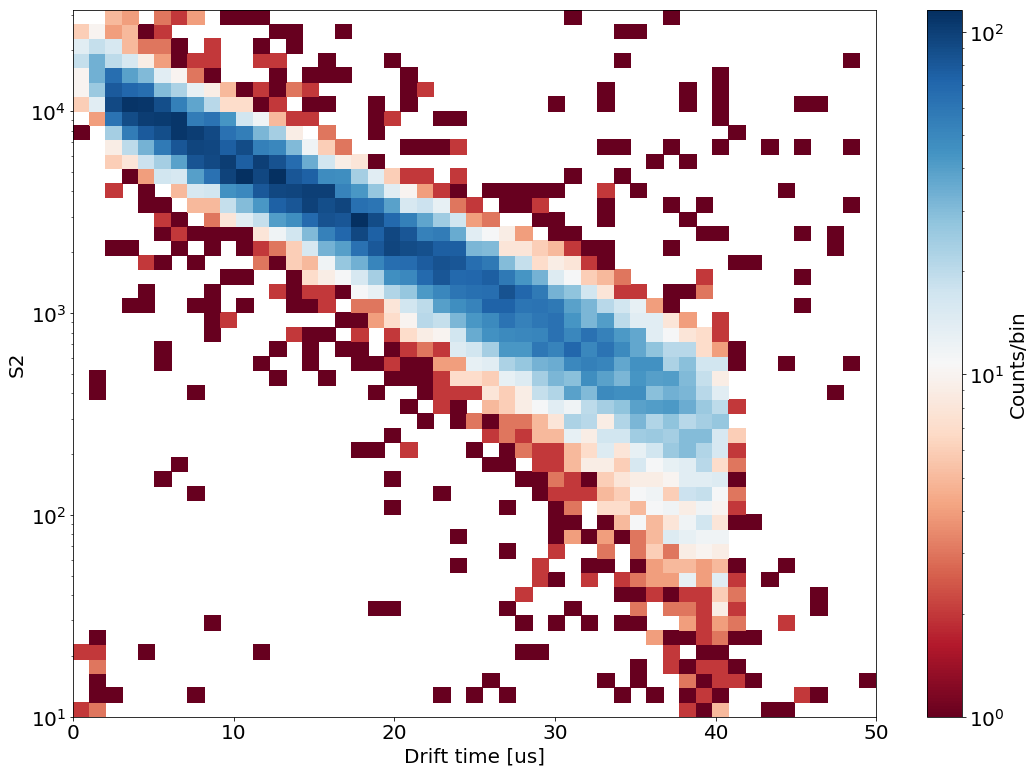

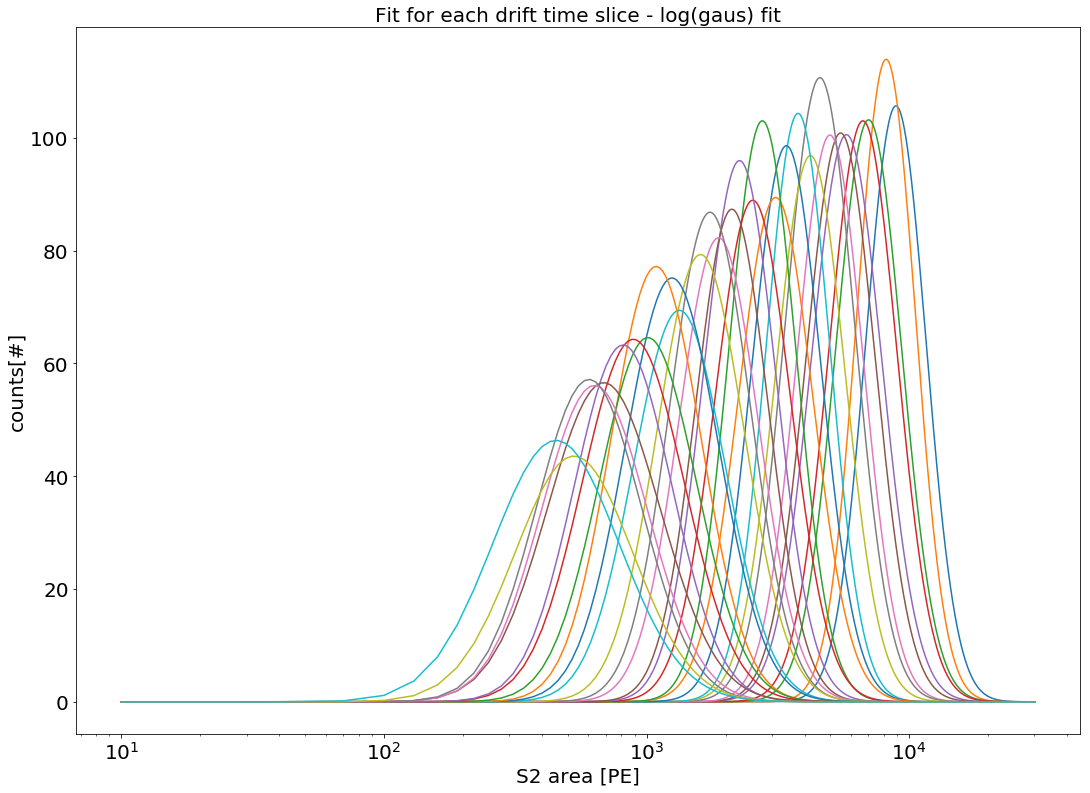

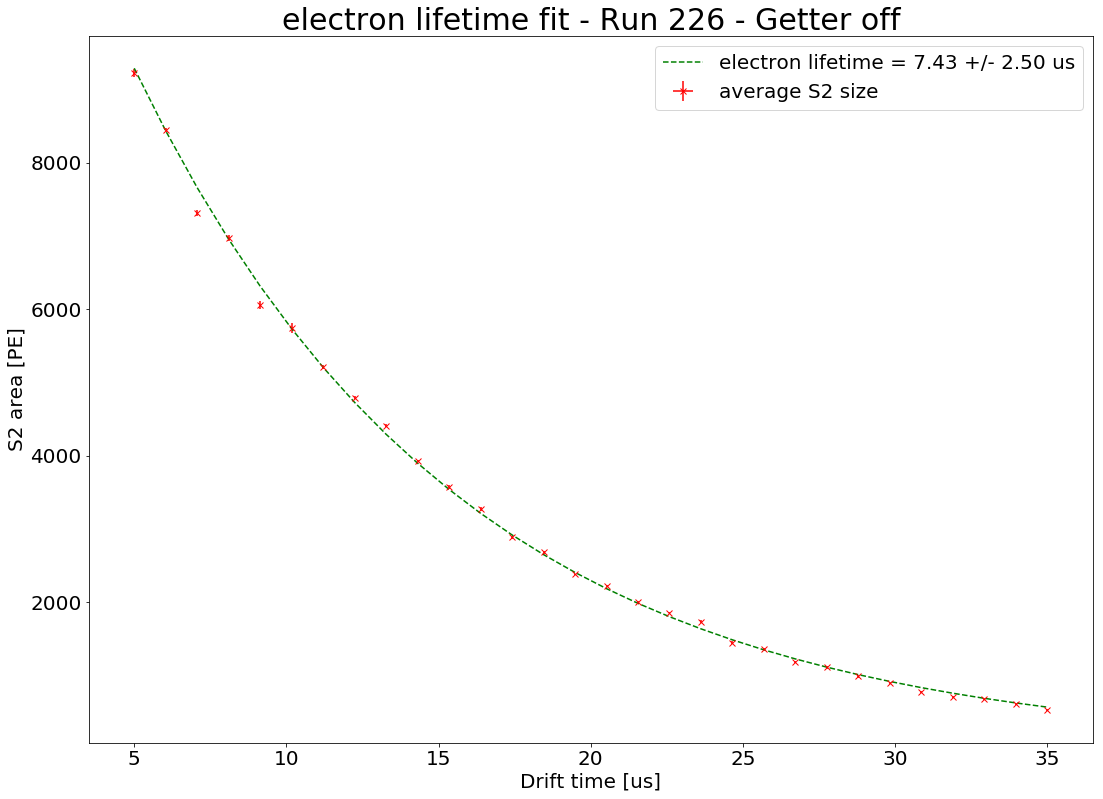

[53.63  0.   20.54 ... 23.3  26.78  0.  ]
this is lamba:  0.10507496466418048
this is 1/lamba:  9.517014858829592
electron lifetime:  6.60 +/- 6.13


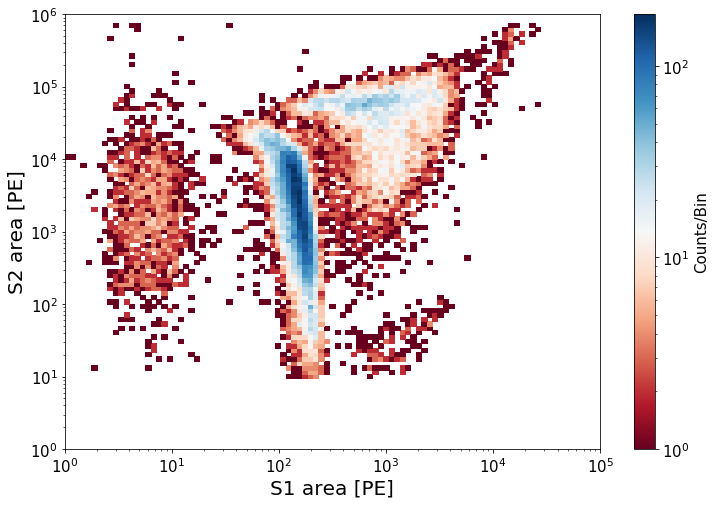

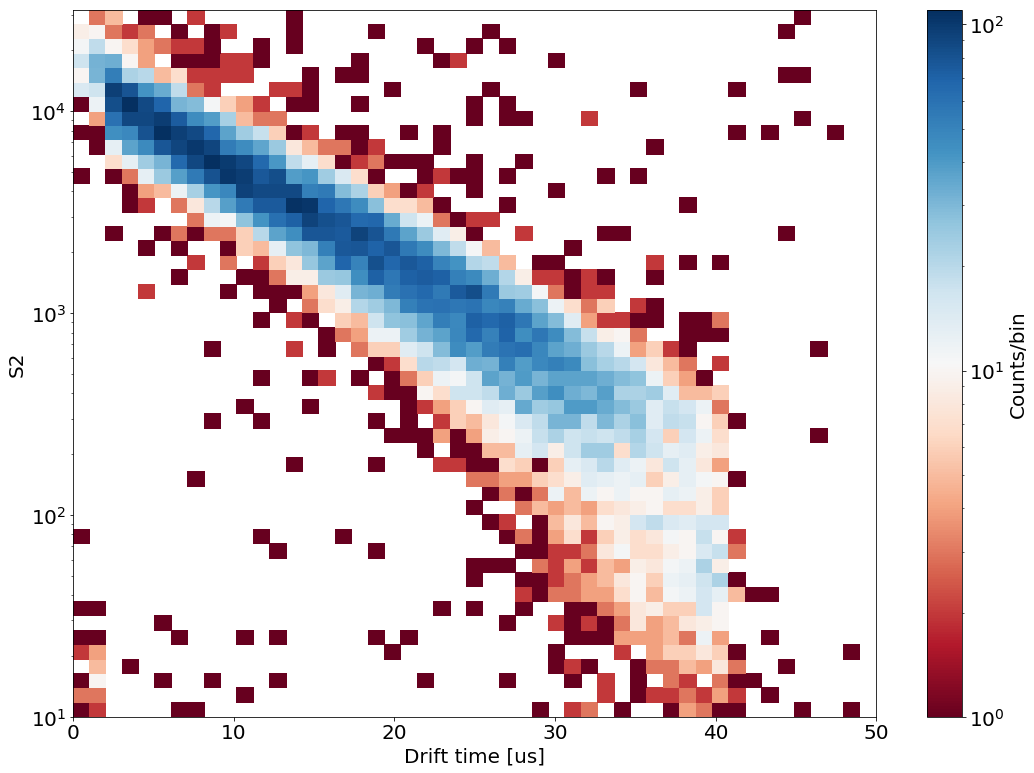

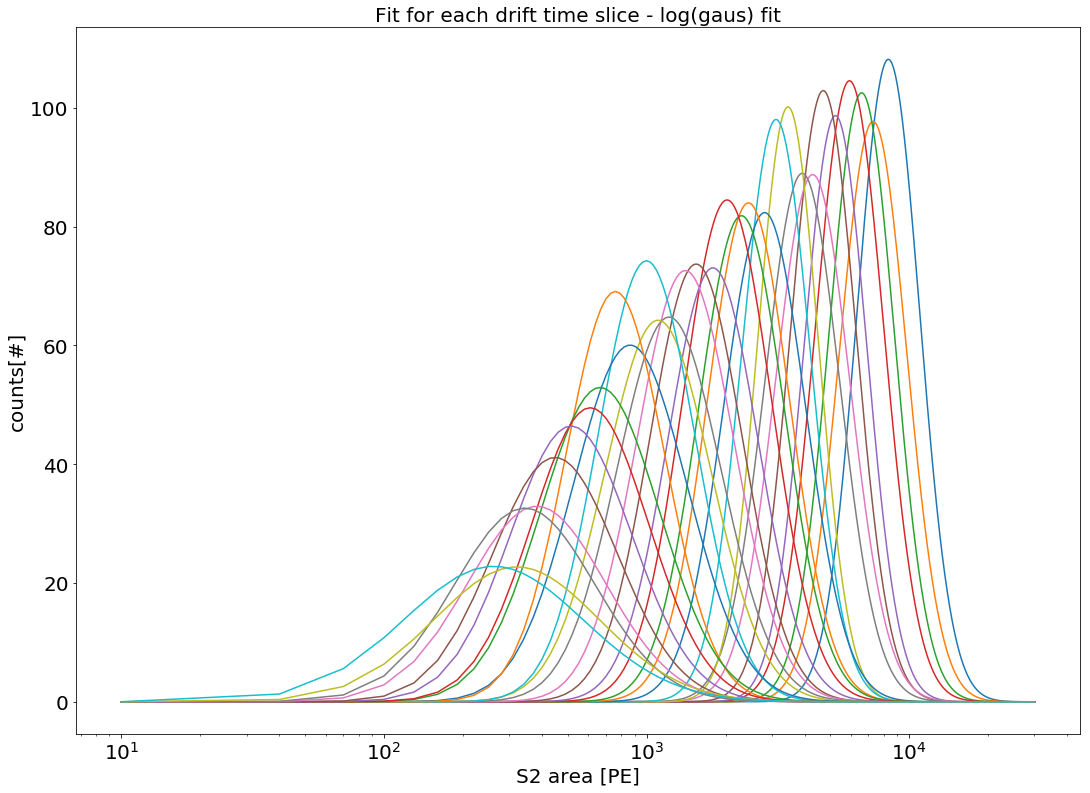

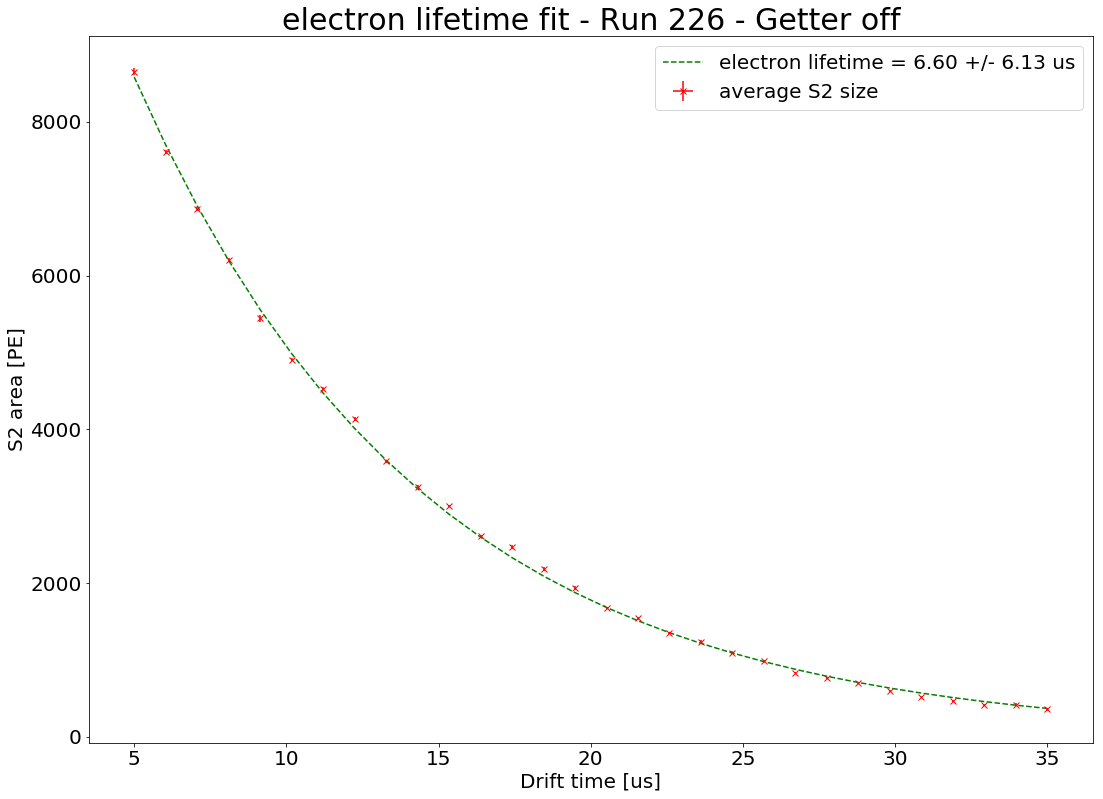

[39.44  7.18  0.   ...  7.37  9.81 37.1 ]
this is lamba:  0.10925434203161703
this is 1/lamba:  9.152954302819477
electron lifetime:  6.34 +/- 7.53


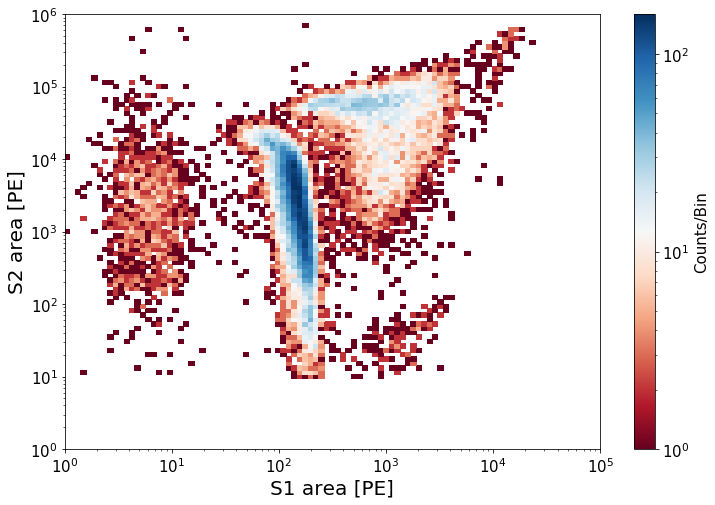

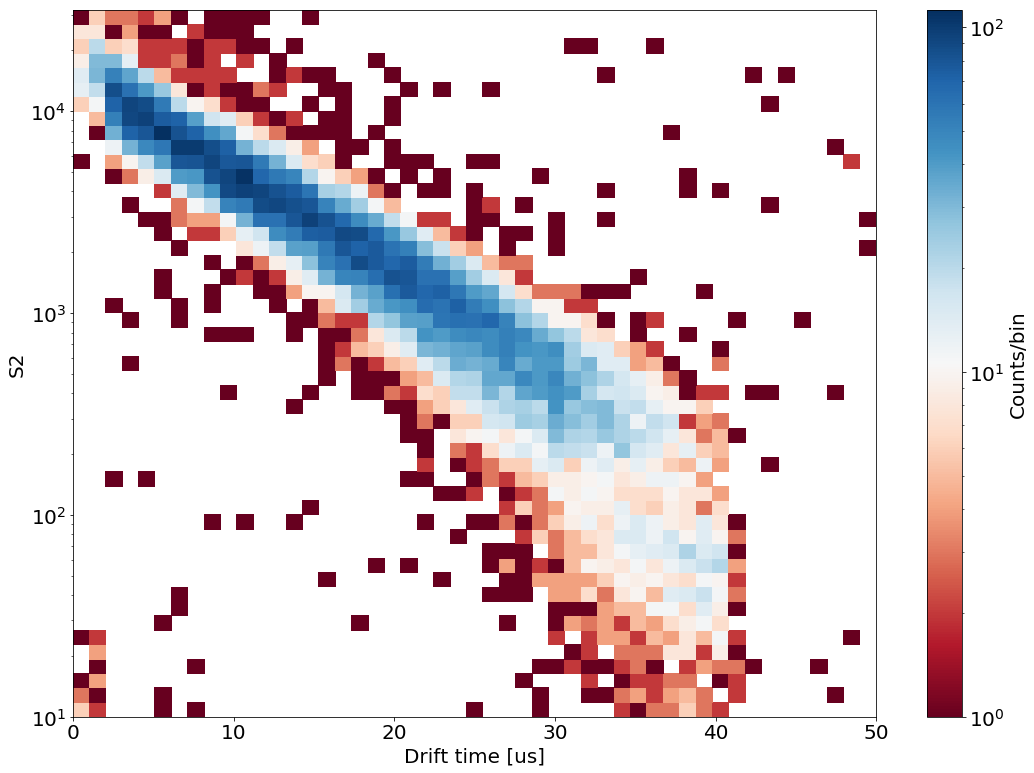

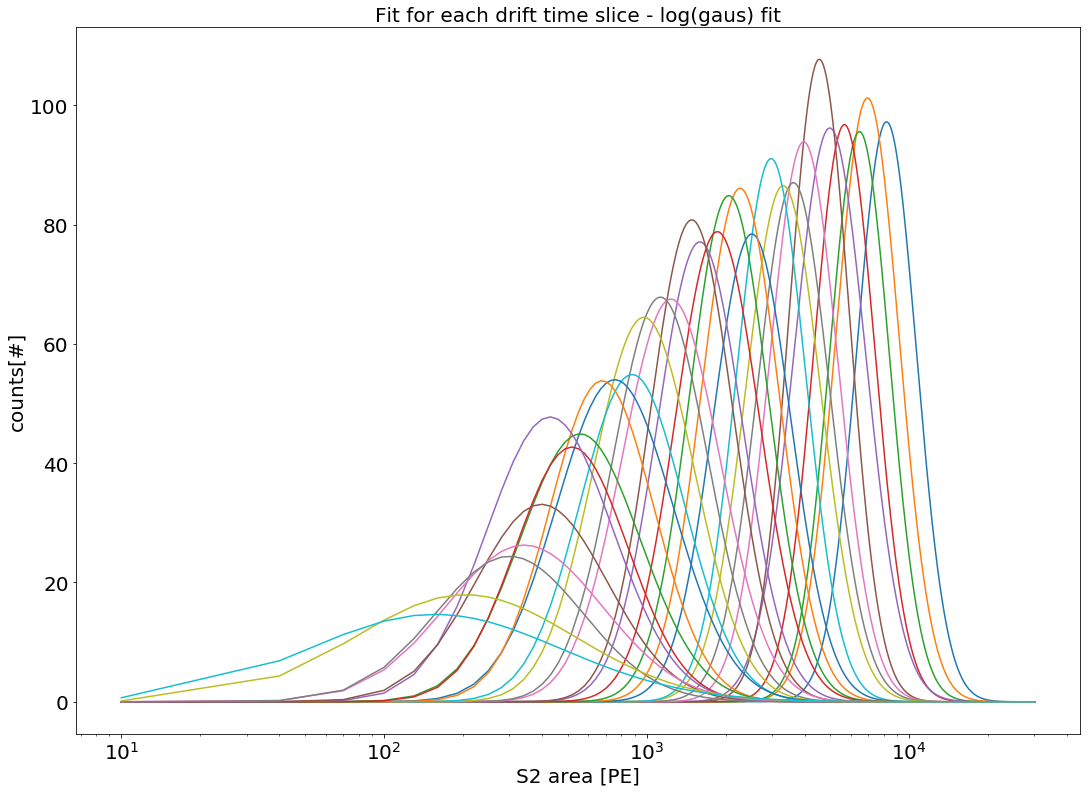

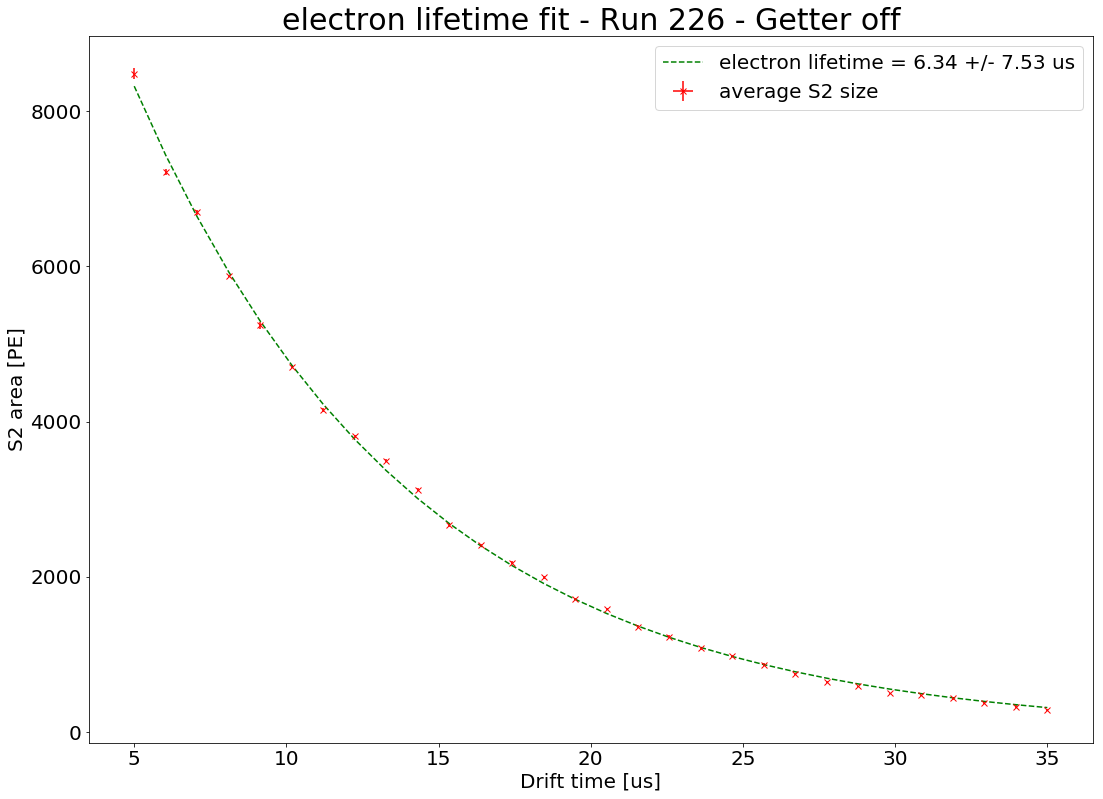

In [203]:



run_list = ['00217', '00218', '00219', '00220', '00221', '00222', '00223', '00224', '00225', '00226', '00227']



Lifetime_list = []
Lifetime_error_list = []

for run in run_list:
    event_basics = ctx.get_array(run, 'event_basics')
    S1_area = event_basics['s1_area']
    S2_area = event_basics['s2_area']

    fig, ax = plt.subplots(figsize=(12,8))
    bins_x = np.logspace(0,5,100)
    bins_y = np.logspace(0,6,100)
    histo_max= 2*10**3

    counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))
    im = ax.pcolormesh(bins_x, bins_y, counts.T, cmap='RdBu', norm=mcolors.LogNorm())
    ax.set_xlabel('S1 area [PE]', fontsize = 20)
    ax.set_ylabel('S2 area [PE]', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xscale('log')
    ax.set_yscale('log')
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(label ='Counts/Bin', fontsize=15)  
    
    line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
    fig, ax = plt.subplots(figsize=(18,13))
    bins_x = np.linspace(0,50,50)
    bins_y = np.logspace(1,4.5,50)
    counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))
    print(line['drift_time']/1e3)
    im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
    plt.colorbar(im,ax=ax, label='Counts/bin')
    ax.set_yscale('log')
    ax.set_xlabel('Drift time [us]')
    ax.set_ylabel('S2')
    
    xcenter = ((xedges[:-1]+xedges[1:])/2)
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    
    fig, ax = plt.subplots(figsize=(18,13))
    fit_range= np.linspace(10,30000,1000)

    def single_gaus(x, h, mu, sigma):

        gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
        return gaus
    p0 = [60,8,8]
    mu_list = []
    mu_error_list = []
    # popt, pcov = curve_fit(single_gaus, ycenter, counts[27], p0)
    # plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
    # plt.plot(fit_range, single_gaus(fit_range, *popt))
    ax.set_xscale('log')
    ax.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
    ax.set_xlabel('S2 area [PE]', fontsize = 20)
    ax.set_ylabel('counts[#]', fontsize = 20)
    for i in range(5,35):   
        popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0)
        plt.plot(fit_range, single_gaus(fit_range, *popt))
        #value = np.exp(popt[1])
        value = np.exp(popt[1]+((popt[2]**2)/2))
        mu_list.append(value)
        perr = np.sqrt(np.diag(pcov))
        error_ln_mu = perr[1]
        error_mu = np.exp(popt[1])*error_ln_mu
        mu_error_list.append(error_mu)


    def expo(x, a, b):
        return a*np.exp(-b*x)

    fig, ax =plt.subplots(figsize = (18,13))
    p0=  [10000,0.1]
    x = np.linspace(5,35,30)
    y_values = mu_list
    y_error = mu_error_list

    SIZE = 20
    EXTRA_SIZE = 30

    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)
    
    popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
    # lifetime = 1/popt[1]
    # lifetime_error = (1/(popt[1]**2))*perr[1]
    lifetime = "%.2f" % (1/popt[1]*np.log(2))
    lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])

    plt.errorbar(x, y_values, yerr=y_error, xerr=0, fmt = 'rx', label = 'average S2 size' )

    print('this is lamba: ', popt[1])
    print('this is 1/lamba: ', 1/popt[1] )
    plt.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
    
    # print(y_error)


    #ax.set_ylim([130,250])
    ax.set_title('electron lifetime fit - Run 226 - Getter off')
    ax.set_xlabel('Drift time [us]')
    ax.set_ylabel('S2 area [PE]')


    print('electron lifetime: ', lifetime, '+/-', lifetime_error)
    # print(perr)
    plt.legend(prop={'size': 20})
    Lifetime_list.append(lifetime)
    Lifetime_error_list.append(lifetime_error)
    plt.show()




In [205]:
print(Lifetime_list)
print(Lifetime_error_list)

['113.96', '101.16', '66.59', '32.74', '20.82', '14.94', '11.39', '8.81', '7.43', '6.60', '6.34']
['174.68', '87.45', '68.37', '11.00', '14.27', '6.87', '3.34', '1.92', '2.50', '6.13', '7.53']


In [35]:

####218 -250 slices 5-35####
Lifetime_all = ['101.16', '66.59', '32.74', '20.82', '14.94', '11.39', '8.81', '7.43', '6.60','6.34', '6.52', '7.30', '8.71', '9.93', '11.51', '13.49', '15.63', '18.25', '20.34', '23.41', '25.90', '28.58', '32.21', '34.43', '38.71', '39.79', '43.02', '44.67', '47.59', '51.78', '53.92', '55.85', '56.98']
Lifetime_error_all = ['87.45', '68.37', '11.00', '14.27', '6.87', '3.34', '1.92', '2.50', '6.13', '7.53', '5.26', '3.53', '3.44', '2.63', '3.33', '4.88', '4.41', '5.52', '5.34', '5.25', '12.62', '7.84', '10.01', '15.85', '17.76', '16.83', '27.58', '23.74', '20.74', '29.11', '19.49', '31.84', '30.98']

 


Electron_lifetime_all = [float(i) for i in Lifetime_all] * 1/(np.log(2))
Electron_lifetime_error_all = [float(j) for j in Lifetime_error_all]


Time = [0,17,47,77,107,137,167,197,227, 240, 257,287, 317,347,377,407,437,467,497,527,557,587,617,647,677,707,737,767,797,827, 857,887,917]
Time_off = [0,17,47,77,107,137,167,197,227,240]
Time_on = [240, 257,287, 317,347,377,407,437,467,497,527,557,587,617,647,677,707,737,767,797,827, 857,887, 917]

######218 - 227 with slices 5-35######
Electron_lifetime_off = ['101.16', '66.59', '32.74', '20.82', '14.94', '11.39', '8.81', '7.43', '6.60','6.34']
Electron_lifetime_off_error = ['87.45', '68.37', '11.00', '14.27', '6.87', '3.34', '1.92', '2.50', '6.13','7.53']

######227 - 250 with slices 5-35######
Electron_lifetime_on = ['6.34', '6.52', '7.30', '8.71', '9.93', '11.51', '13.49', '15.63', '18.25', '20.34', '23.41', '25.90', '28.58', '32.21', '34.43', '38.71', '39.79', '43.02', '44.67', '47.59', '51.78', '53.92', '55.85', '56.98']
Electron_lifetime_on_error = ['7.53', '5.26', '3.53', '3.44', '2.63', '3.33', '4.88', '4.41', '5.52', '5.34', '5.25', '12.62', '7.84', '10.01', '15.85', '17.76', '16.83', '27.58', '23.74', '20.74', '29.11', '19.49', '31.84', '30.98']

Electron_lifetime_off = [float(i) for i in Electron_lifetime_off] * 1/(np.log(2))
Electron_lifetime_on = [float(j) for j in Electron_lifetime_on] * 1/(np.log(2))
Electron_lifetime_on = list(Electron_lifetime_on)
Electron_lifetime_off = list(Electron_lifetime_off)
Electron_lifetime_on_error = [float(i) for i in Electron_lifetime_on_error]
Electron_lifetime_off_error = [float(i) for i in Electron_lifetime_off_error]
print(len(Time))
print(Electron_lifetime_on)

33
[9.146686559236029, 9.40637166659604, 10.531673798489432, 12.565873806142873, 14.325961756027407, 16.60541992063197, 19.46195610159212, 22.5493234890945, 26.329184496223583, 29.344417131681517, 33.773490907210636, 37.36580155902415, 41.23222426860657, 46.46920726703351, 49.67199025780701, 55.846725032811776, 57.40483567697186, 62.06474065904321, 64.44518747651, 68.65785699590577, 74.70274921723053, 77.79011660473292, 80.57451803364862, 82.20476342985313]


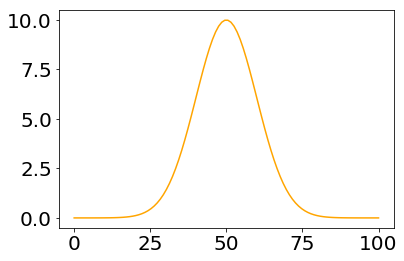

In [14]:
def expo(x, a, b,c):
    return a*np.exp(-b*x)+c

def gaus(x, h, mu, sigma):
    gaus = h * np.exp(-(x-mu)**2         /(2*sigma**2))
    return gaus

axis_range = np.linspace(0,100,100)
plt.plot(axis_range, gaus(axis_range,10,50,10), color = 'orange')
plt.show()

[145.94303034  96.06906277  47.23383564  30.03691075  21.55386391
  16.43229652  12.71014331  10.71922415   9.52178727   9.14668656
   9.40637167  10.5316738   12.56587381  14.32596176  16.60541992
  19.4619561   22.54932349  26.3291845   29.34441713  33.77349091
  37.36580156  41.23222427  46.46920727  49.67199026  55.84672503
  57.40483568  62.06474066  64.44518748  68.657857    74.70274922
  77.7901166   80.57451803  82.20476343]
fit parameters for linear fit are:  m= 0.11767200166731237 b=  -25.602495783268083


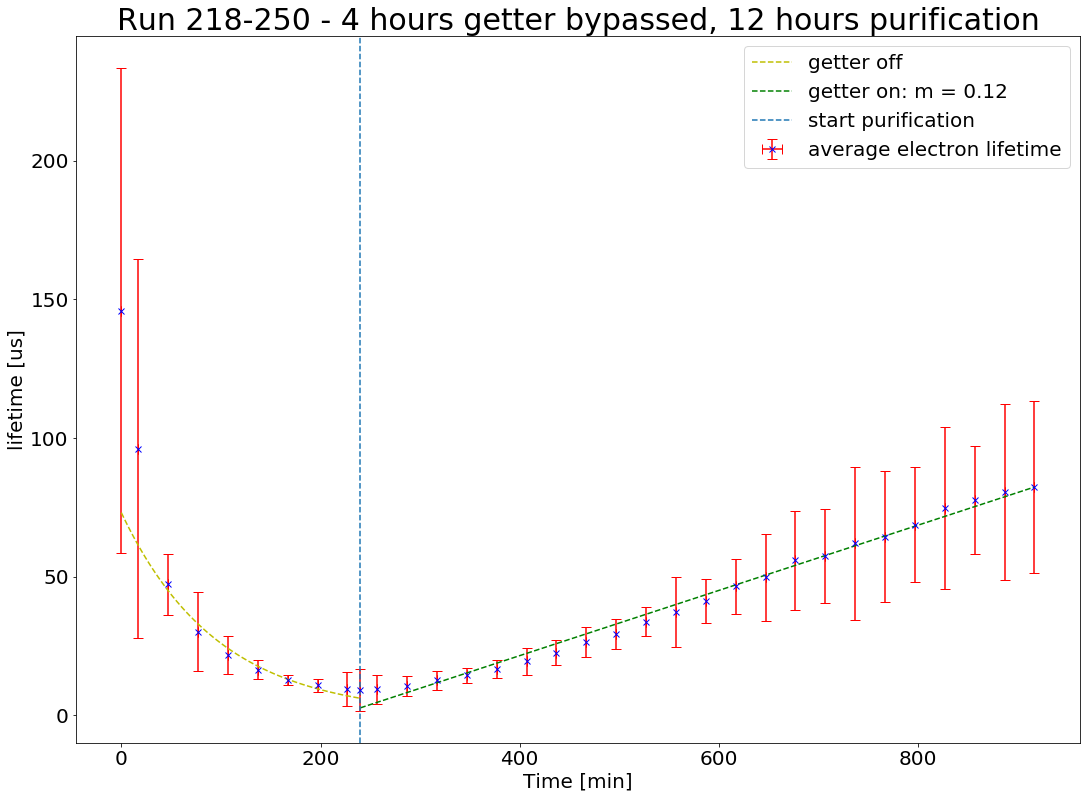

In [36]:
# print(Time_off)
# print(Electron_lifetime_off)
# print(Electron_lifetime_off_error)

# def expo(x, a, b,c,d):
#     return a - b* (  np.exp(-((np.log(2))/c)*(x-d))   )

def expo_off(x, a, b):
    return a*np.exp(-b*x)

fig, ax =plt.subplots(figsize = (18,13))

p0= [100, 0.1]
bounds_off = ((0,0),(500, np.inf))

Time_range_on = np.linspace(240,917,100)
Time_range_off = np.linspace(0,240,100)


# Electron_lifetime_all = [x / 41 for x in Electron_lifetime_all]
# Electron_lifetime_error_all = [x / 41 for x in Electron_lifetime_error_all]
# Electron_lifetime_on = [x / 41 for x in Electron_lifetime_on]
# Electron_lifetime_off = [x / 41 for x in Electron_lifetime_off]
# Electron_lifetime_off_error = [x / 41 for x in Electron_lifetime_off_error]

popt_off, pcov_off = curve_fit(expo_off, Time_off, Electron_lifetime_off,sigma=Electron_lifetime_off_error, p0=p0, bounds = bounds_off, absolute_sigma=True, maxfev= 10000)
#popt_on, pcov_on = curve_fit(linear_on, Time_on, Electron_lifetime_on,sigma=Electron_lifetime_on_error, p0=p0, absolute_sigma=True, maxfev= 10000)
print(Electron_lifetime_all)



SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)



plt.errorbar(Time, Electron_lifetime_all, yerr=Electron_lifetime_error_all, xerr=0, ecolor='red', capsize=5, fmt = 'bx', label = 'average electron lifetime' )
plt.plot(Time_range_off, expo_off(Time_range_off, *popt_off), 'y--', label= 'getter off')

m,b = np.polyfit(Time_on,Electron_lifetime_on , 1)
print('fit parameters for linear fit are: ', 'm=',m , 'b= ',b)
m = "%.2f" % m
fit=np.polyfit(Time_on,Electron_lifetime_on , 1)
fit_fn = np.poly1d(fit)
plt.plot(Time_on, fit_fn(Time_on), 'g--', label = 'getter on: m = '+str(m))

ax.axvline(x=240, ymin=0, ymax=2, linestyle = '--', label ='start purification')
ax.set_title('Run 218-250 - 4 hours getter bypassed, 12 hours purification')
ax.set_xlabel('Time [min]')
ax.set_ylabel('lifetime [us]')
plt.legend(prop={'size': 20})
plt.show()